# Build some toy models and how to sample them

In [1]:
# use autoreload
%load_ext autoreload
%autoreload 2

import yaml
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import seaborn as sns


## Embed of low pT and high pt tracks

In [3]:
with open("configs/4c_testing.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/UnsupervisedLearning/JEPA/ToyTrack/2_testing/artifacts/best-92512mhb-val_loss=0.003267-epoch=99.ckpt"

# Use lightning load
model = TrueContrastiveLearning.load_from_checkpoint(checkpoint_path).to("cuda")

# Make sure the model has low pT tracks
model.hparams["dataset_args"]["particle_guns"][0]["pt"] = [2.5, 2.6]

# Set the model to also have a larger batch size
model.hparams["batch_size"] = 2000

# Get dataloader
dataloader = model.train_dataloader()

# Get a batch
batch = next(iter(dataloader))

Max edge index: 19
Distances shape: torch.Size([380000])
Sample distances: tensor([2.4164e-02, 7.0801e-02, 7.8432e-02, 5.5617e+01, 5.5617e+01],
       device='cuda:0')


/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/pytorch/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


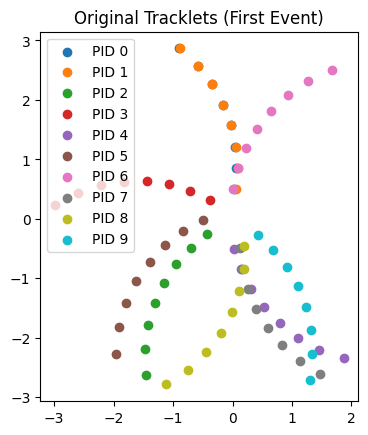

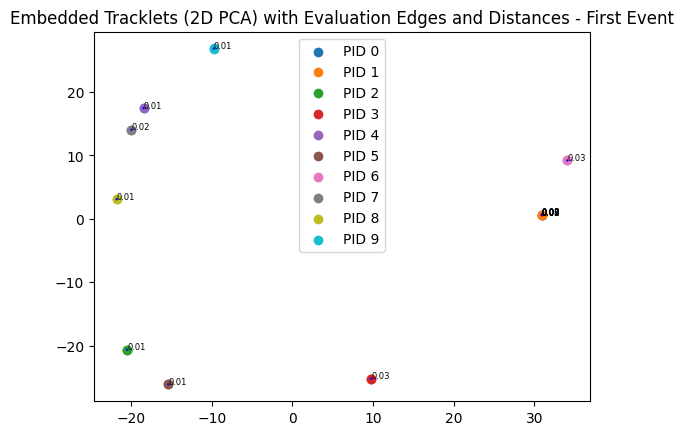

First Batch Metrics:
  Efficiency: 1.0000
  Purity: 0.9103
  Mean True Distance: 0.0216
  Mean Fake Distance: 39.4408


In [5]:
with torch.no_grad():
    batch = {k: v.to("cuda") if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    results = model.shared_evaluation(batch, batch_idx=0)

# Get the embeddings
low_pt_embeddings = results["embeddings"].cpu().numpy()

Max edge index: 19
Distances shape: torch.Size([380000])
Sample distances: tensor([ 0.1921,  7.4821,  7.4629, 48.3710, 48.6396], device='cuda:0')


/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/lightning/pytorch/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


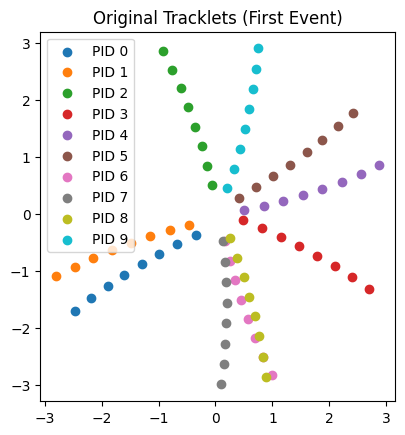

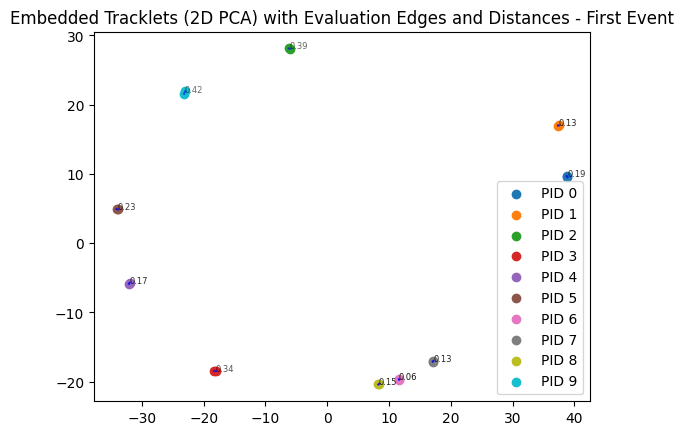

First Batch Metrics:
  Efficiency: 1.0000
  Purity: 0.8495
  Mean True Distance: 0.2301
  Mean Fake Distance: 39.6710


In [6]:
# Now set tracklet pT to be high
model.hparams["dataset_args"]["particle_guns"][0]["pt"] = [10, 11]

# Get dataloader
dataloader = model.train_dataloader()

# Get a batch
batch = next(iter(dataloader))
with torch.no_grad():
    batch = {k: v.to("cuda") if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    results = model.shared_evaluation(batch, batch_idx=0)

# Get the embeddings
high_pt_embeddings = results["embeddings"].cpu().numpy()

In [9]:
# Select embeddings for the first batch entry
low_pt_embeddings = low_pt_embeddings.reshape(-1, 8)  # Shape: (400*20, 8)
high_pt_embeddings = high_pt_embeddings.reshape(-1, 8)  # Shape: (400*20, 8)

# Create a mask for low and high pT embeddings
num_low_pt = low_pt_embeddings.shape[0]  # 400*20
num_high_pt = high_pt_embeddings.shape[0]  # 400*20

low_pt_mask = np.ones(num_low_pt, dtype=bool)       # [True, True, ..., True] (400*20,)
high_pt_mask = np.zeros(num_high_pt, dtype=bool)    # [False, False, ..., False] (400*20,)
pt_mask = np.concatenate([low_pt_mask, high_pt_mask])  # Shape: (2*400*20,)

# Concatenate low and high pT embeddings for the first batch
all_embeddings = np.concatenate([low_pt_embeddings, high_pt_embeddings], axis=0)  # Shape: (2*400*20, 8)

# Save all embeddings for quick reload, and the mask
np.savez("all_embeddings.npz", all_embeddings, pt_mask)

## Load the embeddings and mask

In [2]:
# Load embeddings, mask and remake arrays
data = np.load("all_embeddings.npz")
all_embeddings = data["arr_0"]
pt_mask = data["arr_1"]

low_pt_embeddings = all_embeddings[pt_mask]
high_pt_embeddings = all_embeddings[~pt_mask]

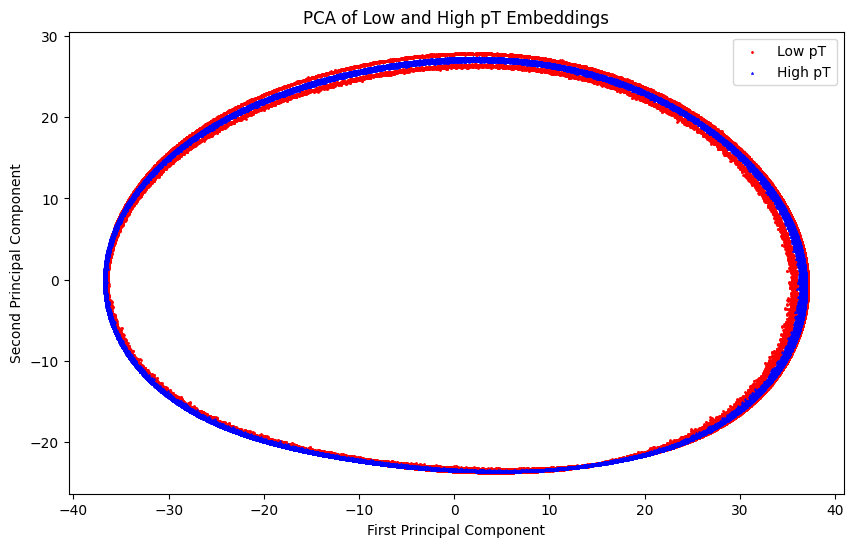

In [3]:
# Plot ALL the embeddings in PCA

from sklearn.decomposition import PCA

# Perform PCA on the concatenated embeddings
pca = PCA(n_components=2)
all_embeddings_pca = pca.fit_transform(all_embeddings)  # Shape: (2*400*20, 2)

# Plot the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(
    all_embeddings_pca[pt_mask, 0],
    all_embeddings_pca[pt_mask, 1],
    c="r",
    marker='o',
    label='Low pT',
    s=1
)
plt.scatter(
    all_embeddings_pca[~pt_mask, 0],
    all_embeddings_pca[~pt_mask, 1],
    c="b",
    marker='^',
    label='High pT',
    s=1
)
plt.legend()
plt.title('PCA of Low and High pT Embeddings')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

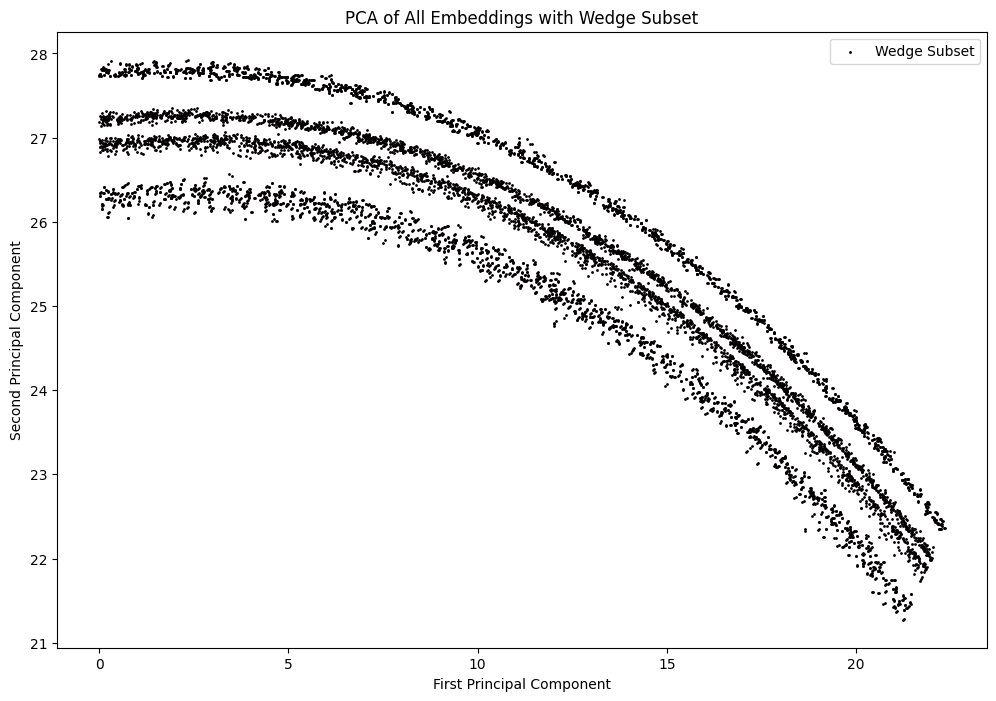

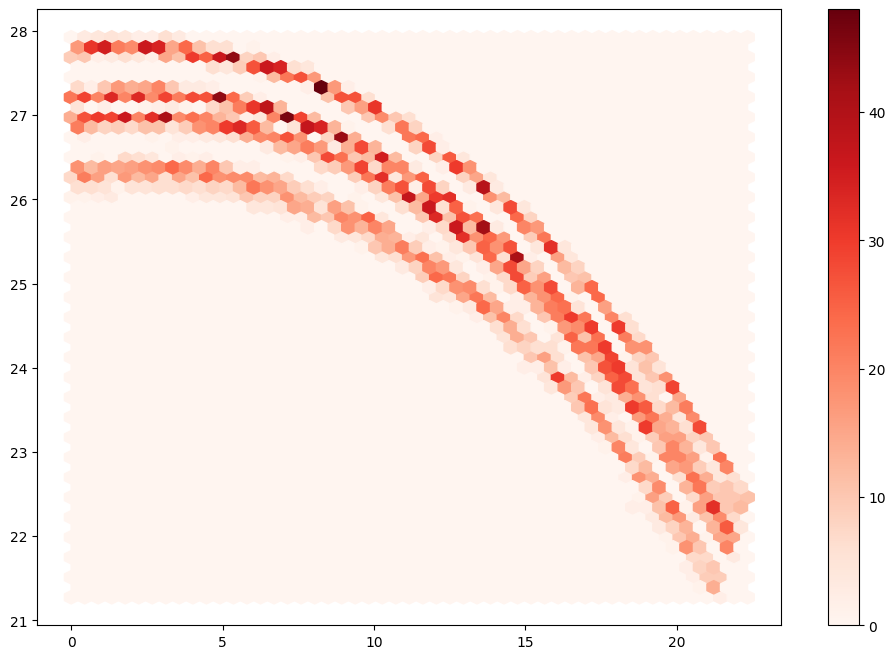

In [4]:
# Select points in the wedge and plot them

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ### Step 1: Prepare the Embeddings

# Reshape embeddings to ensure correct dimensions
low_pt_embeddings = low_pt_embeddings.reshape(-1, 8)   # Shape: (8000, 8)
high_pt_embeddings = high_pt_embeddings.reshape(-1, 8) # Shape: (8000, 8)

# Concatenate low and high pT embeddings
all_embeddings = np.concatenate([low_pt_embeddings, high_pt_embeddings], axis=0)  # Shape: (16000, 8)

# Perform PCA on all embeddings for visualization
pca = PCA(n_components=2)
all_embeddings_pca = pca.fit_transform(all_embeddings)  # Shape: (16000, 2)

# ### Step 2: Create the pT Mask

# Create boolean masks for low and high pT embeddings
num_low_pt = low_pt_embeddings.shape[0]    # 8000
num_high_pt = high_pt_embeddings.shape[0]  # 8000

low_pt_mask = np.ones(num_low_pt, dtype=bool)      # [True, True, ..., True] (8000,)
high_pt_mask = np.zeros(num_high_pt, dtype=bool)   # [False, False, ..., False] (8000,)
pt_mask = np.concatenate([low_pt_mask, high_pt_mask])  # Shape: (16000,)

# ### Step 3: Select a Wedge of Data in PCA Space

# Calculate angles of points in PCA space
angles = np.arctan2(all_embeddings_pca[:, 1], all_embeddings_pca[:, 0])

# Define the wedge range (e.g., between π/4 and π/2)
wedge_min = np.pi / 4
wedge_max = np.pi / 2

# Select points within the wedge
wedge_mask = (angles >= wedge_min) & (angles <= wedge_max)
wedge_indices = np.where(wedge_mask)[0]

# Extract the wedge subset
subset_embeddings = all_embeddings[wedge_indices]        # Shape: (subset_size, 8)
subset_embeddings_pca = all_embeddings_pca[wedge_indices]  # Shape: (subset_size, 2)
subset_pt_mask = pt_mask[wedge_indices]                  # Shape: (subset_size,)

# ### Step 4: Visualize the Wedge Selection

plt.figure(figsize=(12, 8))

# Plot all data points in light gray for context
# plt.scatter(
#     all_embeddings_pca[:, 0],
#     all_embeddings_pca[:, 1],
#     c="lightgray",
#     marker='o',
#     s=1,
#     alpha=0.3,
#     label='All Data'
# )

# Overlay the wedge subset
plt.scatter(
    subset_embeddings_pca[:, 0],
    subset_embeddings_pca[:, 1],
    c="red",
    marker='o',
    s=1,
    edgecolor='k',
    label='Wedge Subset'
)

# Add a legend
plt.legend()

# Set plot titles and labels
plt.title('PCA of All Embeddings with Wedge Subset')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Display the plot
plt.show()

# Make a 2d histogram of the subset embeddings, with hex

plt.figure(figsize=(12, 8))
plt.hexbin(
    x=subset_embeddings_pca[:, 0],
    y=subset_embeddings_pca[:, 1],
    gridsize=50,
    cmap='Reds'
)
plt.colorbar()
plt.show()



## Spectral

In [33]:
# Perform clustering in PCA space

from sklearn.cluster import SpectralClustering

# Initialize the clustering algorithm (spectral clustering as an example)

# Add timing
start_time = time.time()

spectral = SpectralClustering(
    n_clusters=3, 
    affinity='nearest_neighbors', 
    assign_labels='discretize',
    n_neighbors=10,
    n_init=10,
    random_state=42,
    n_jobs=1)
cluster_labels = spectral.fit_predict(subset_embeddings_pca)

# Add timing
end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")


/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Time taken: 14.19 seconds


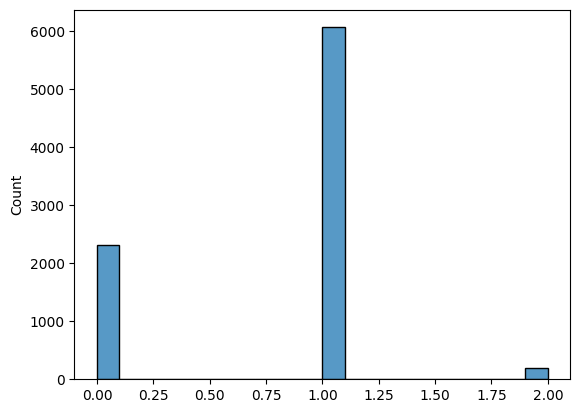

In [43]:
# Histogram the cluster labels with sns
import seaborn as sns
sns.histplot(cluster_labels, bins=20)
plt.show()



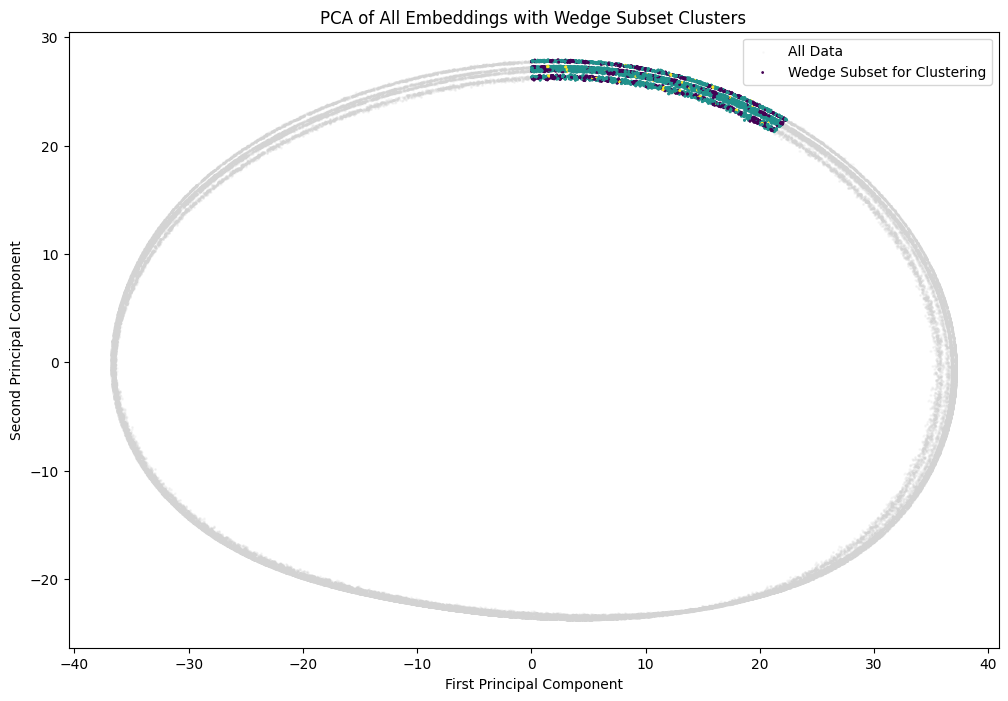

In [44]:
# Visualize the clustering results

plt.figure(figsize=(12, 8))

# Plot all data points in light gray for context
plt.scatter(
    all_embeddings_pca[:, 0],
    all_embeddings_pca[:, 1],
    c="lightgray",
    marker='o',
    s=1,
    alpha=0.1,
    label='All Data'
)

# Overlay the wedge subset with cluster-based coloring
scatter = plt.scatter(
    subset_embeddings_pca[:, 0],
    subset_embeddings_pca[:, 1],
    c=cluster_labels,
    marker='o',
    s=1,
    label='Wedge Subset for Clustering'
)

# Add a legend
plt.legend()

# Set plot titles and labels
plt.title('PCA of All Embeddings with Wedge Subset Clusters')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Display the plot
plt.show()

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Time taken: 0.46 seconds


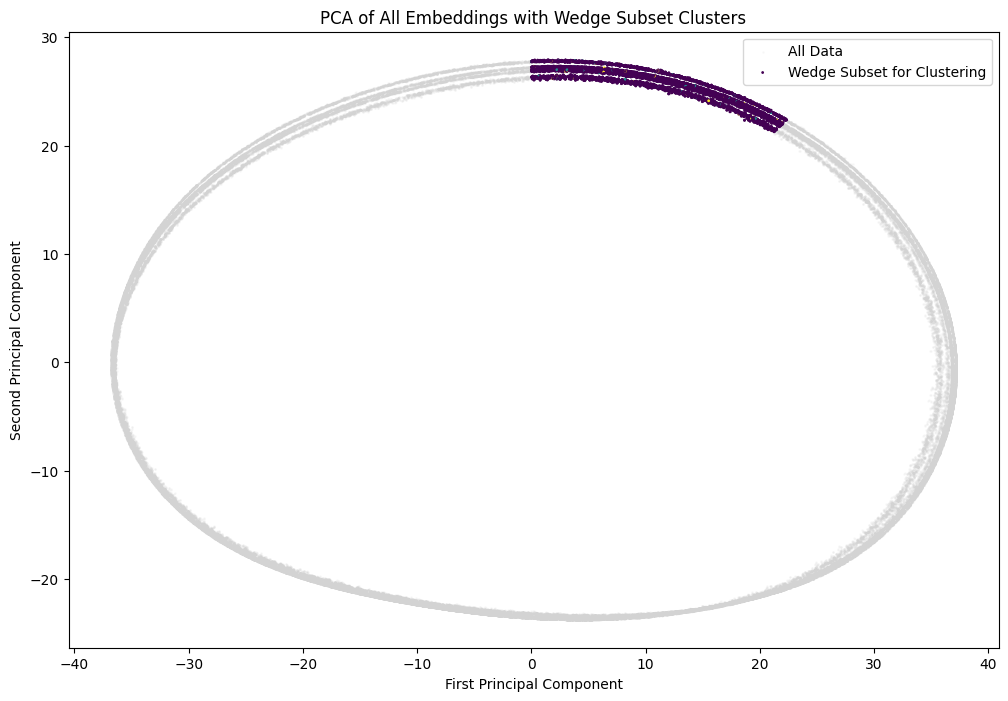

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Time taken: 0.61 seconds


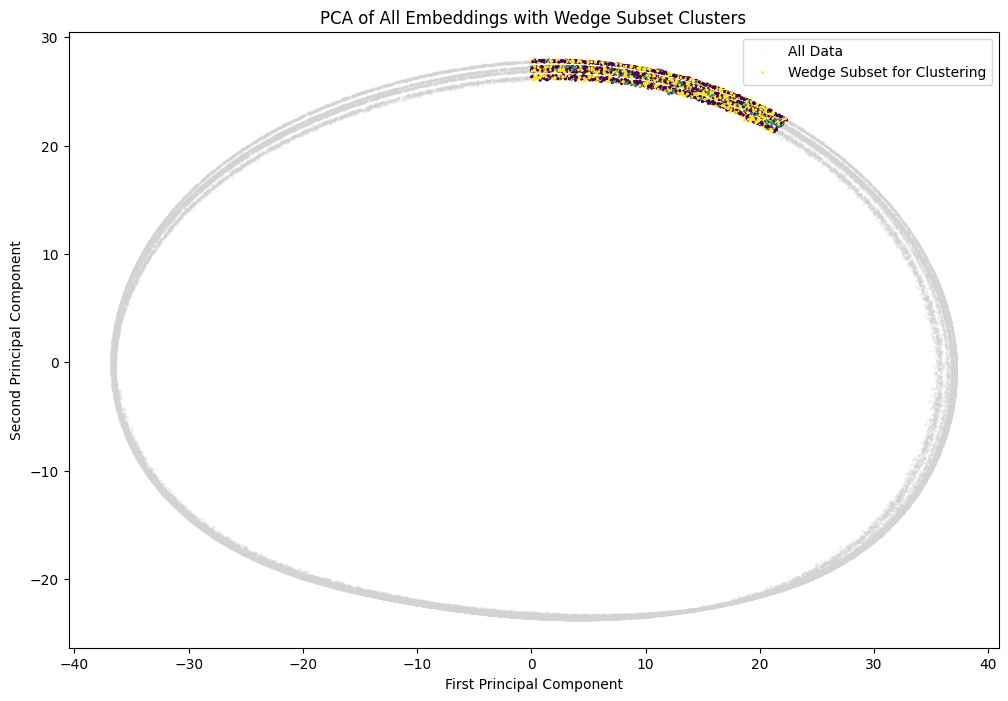

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Time taken: 1.69 seconds


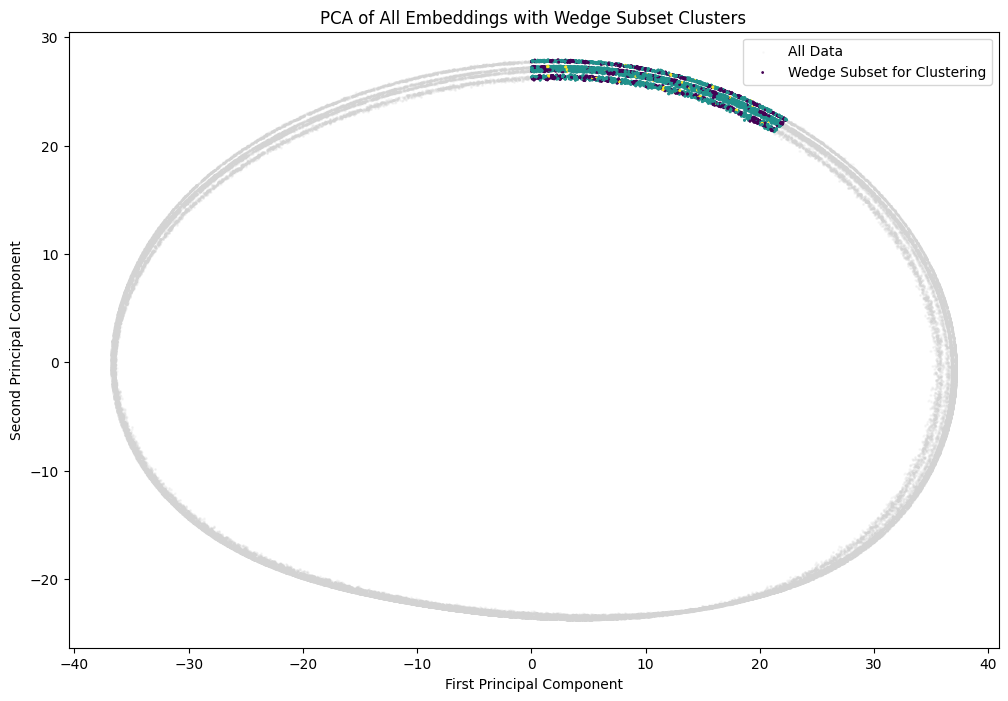

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Time taken: 33.29 seconds


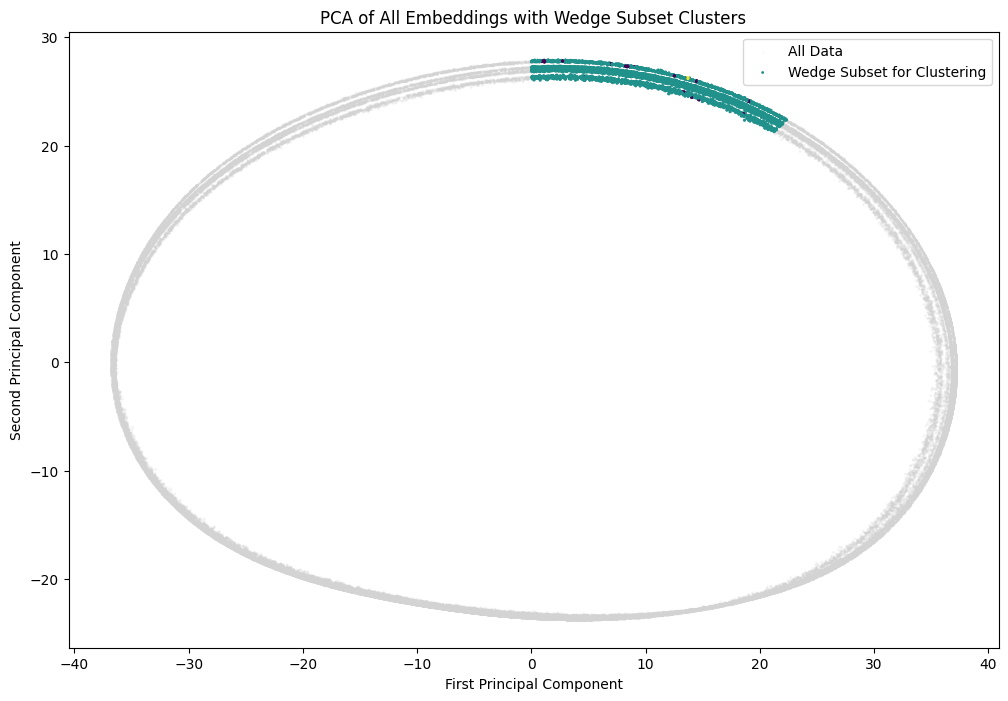

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Time taken: 21.38 seconds


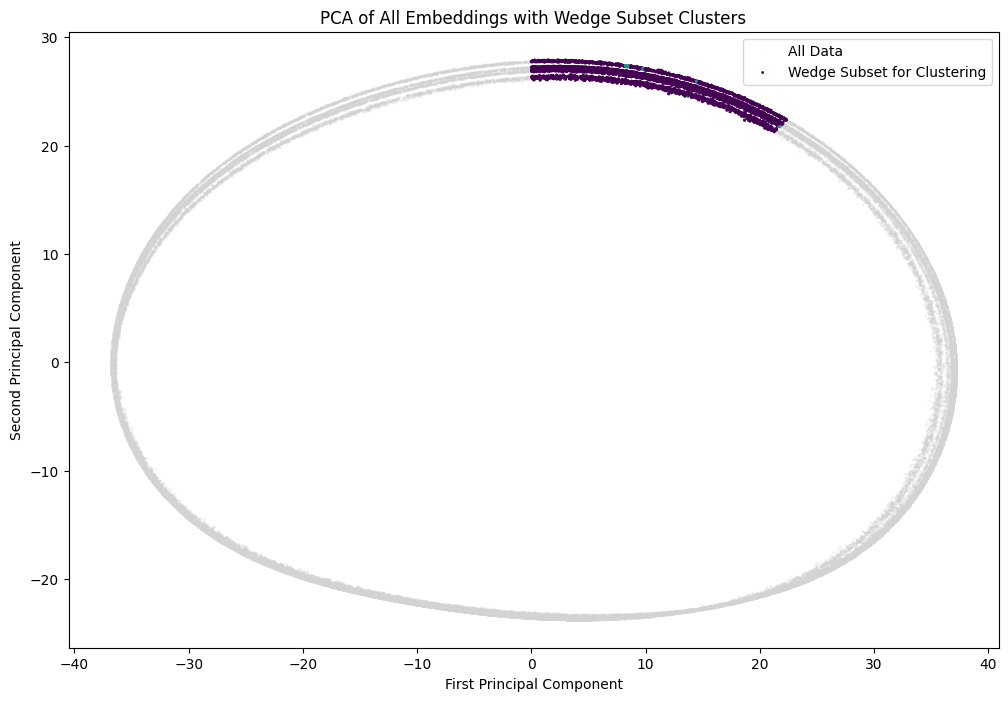

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Time taken: 18.09 seconds


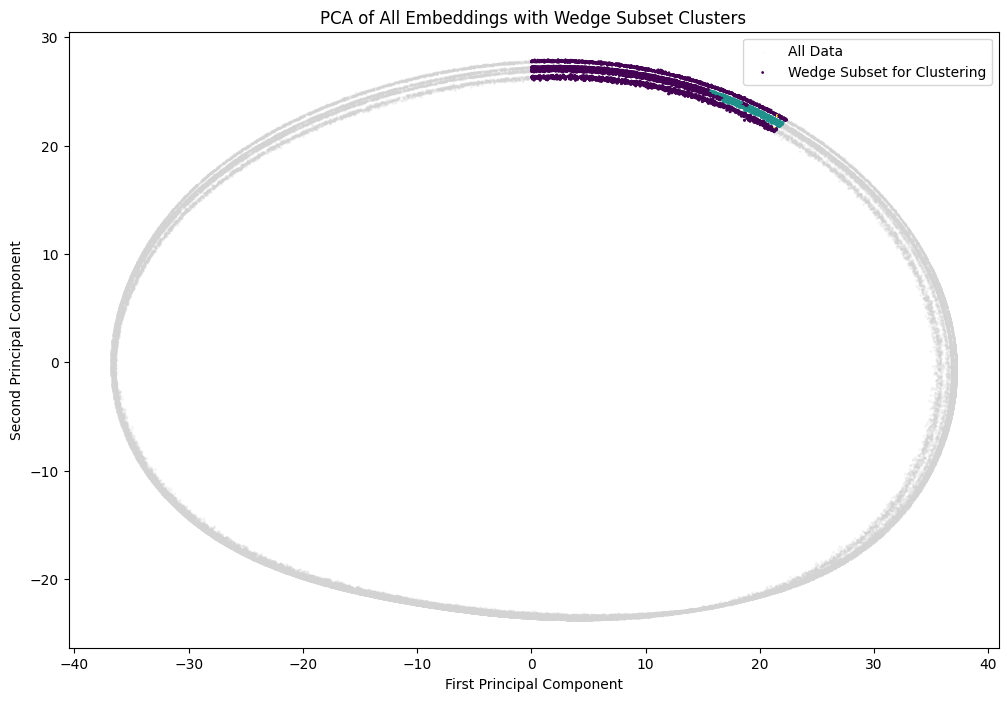

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Time taken: 39.77 seconds


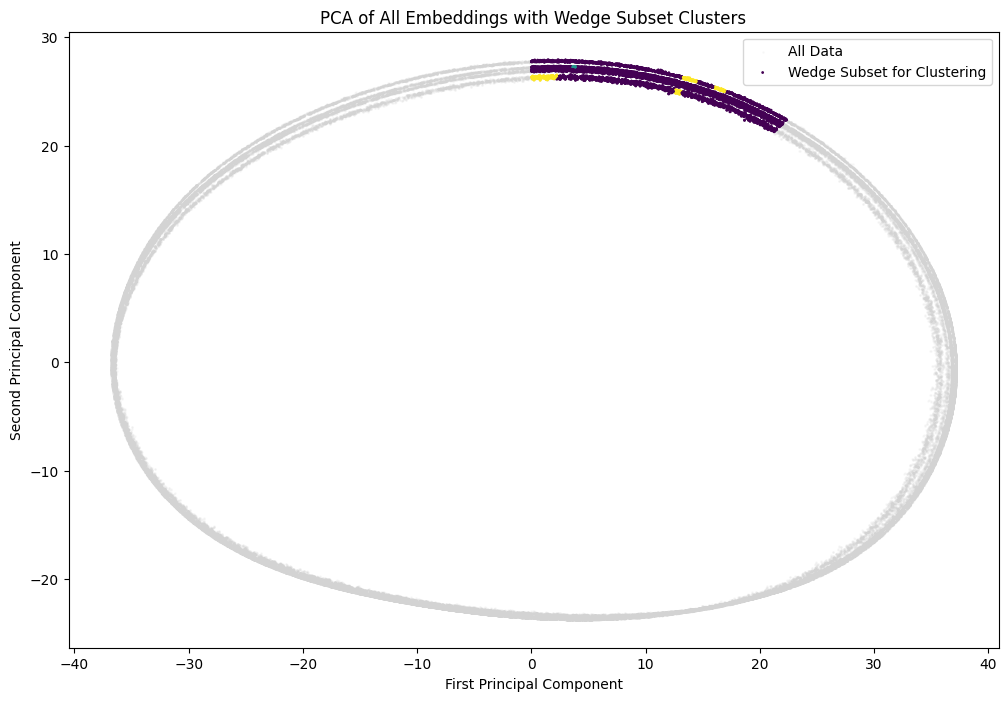

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Time taken: 15.51 seconds


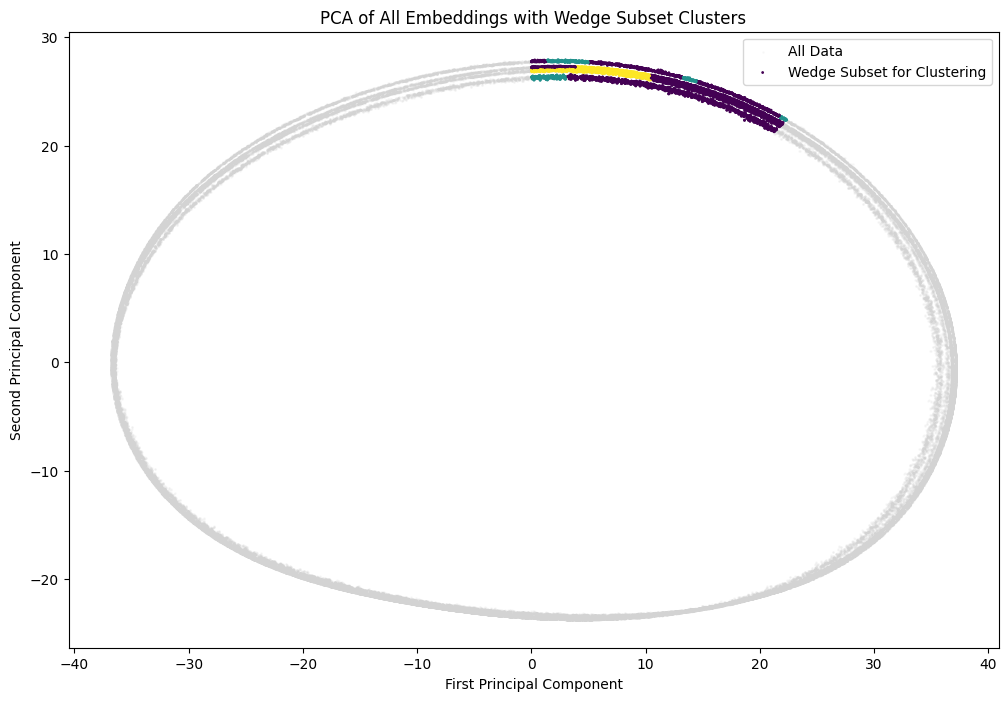

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Time taken: 14.97 seconds


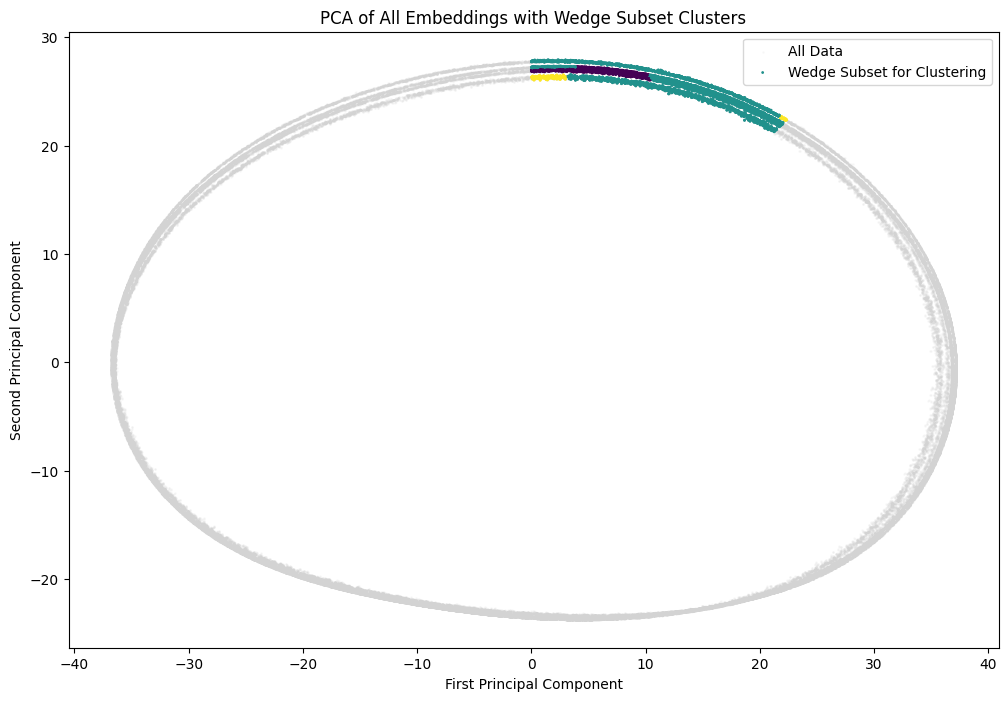

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Time taken: 14.47 seconds


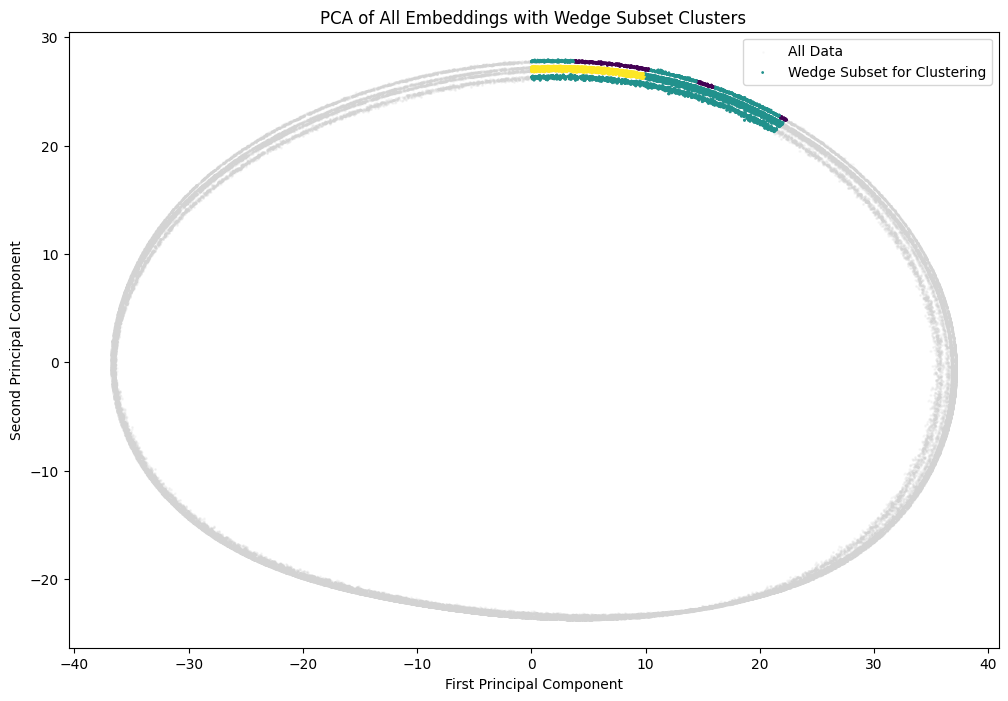

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Time taken: 46.04 seconds


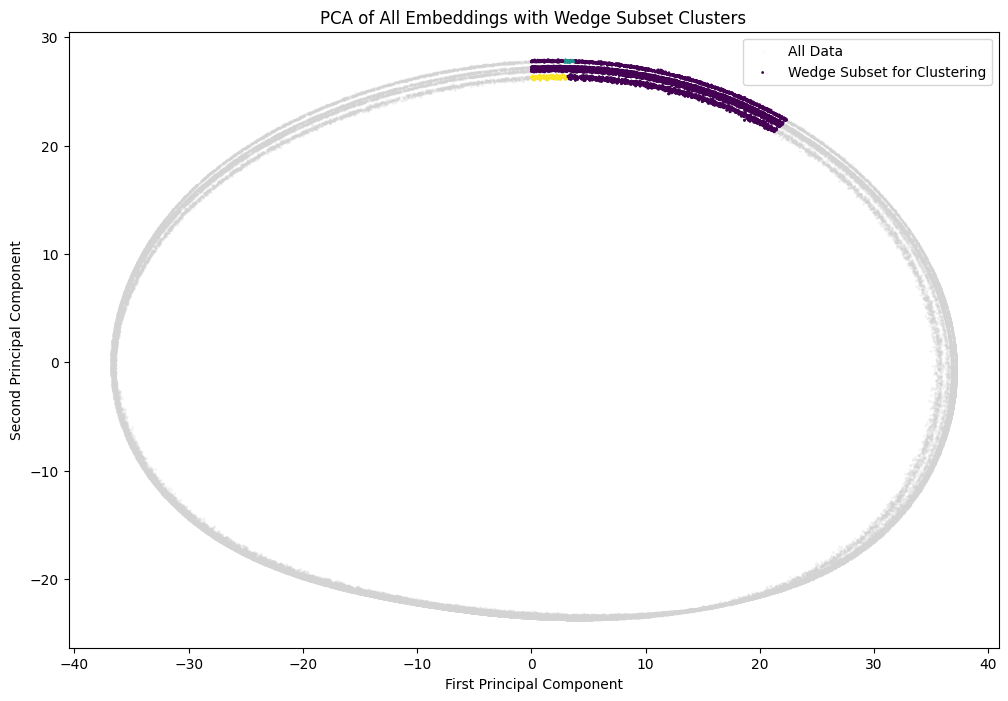

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Time taken: 72.56 seconds


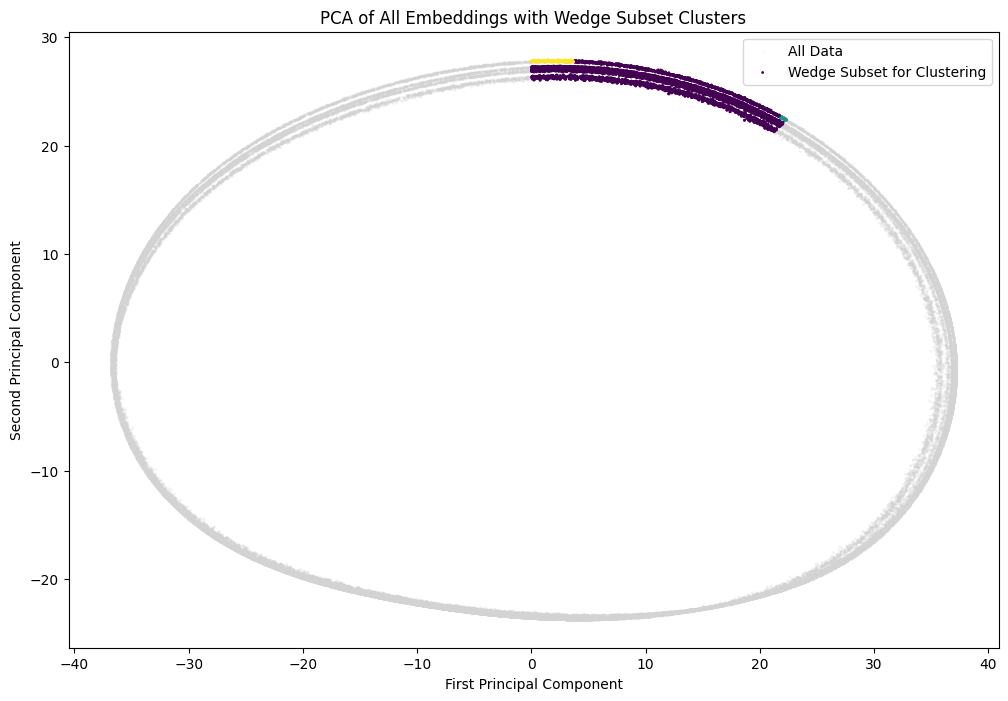

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Time taken: 47.37 seconds


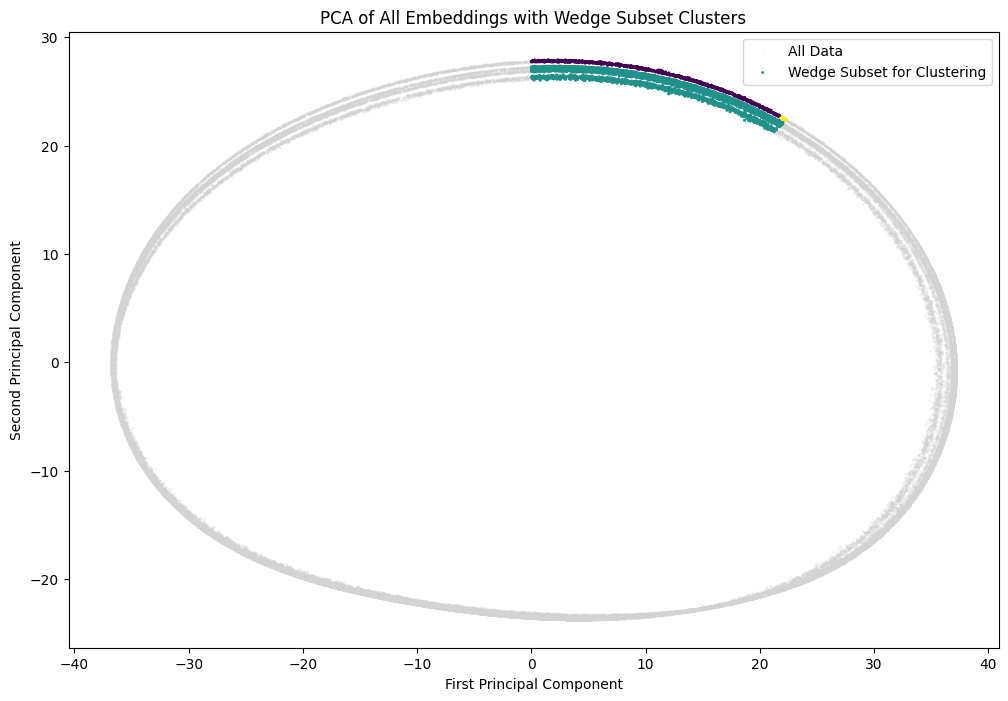

/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

In [45]:
# Perform clustering in PCA space

from sklearn.cluster import SpectralClustering

# Initialize the clustering algorithm (spectral clustering as an example)

n_neighbor_list = np.arange(1, 15)

for n_neighbors in n_neighbor_list:

    # Add timing
    start_time = time.time()

    spectral = SpectralClustering(
        n_clusters=3, 
        affinity='nearest_neighbors', 
        assign_labels='kmeans',
        n_neighbors=n_neighbors,
        random_state=42,
        n_jobs=1)
    cluster_labels = spectral.fit_predict(subset_embeddings_pca)

    # Add timing
    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Visualize the clustering results

    plt.figure(figsize=(12, 8))

    # Plot all data points in light gray for context
    plt.scatter(
        all_embeddings_pca[:, 0],
        all_embeddings_pca[:, 1],
        c="lightgray",
        marker='o',
        s=1,
        alpha=0.1,
        label='All Data'
    )

    # Overlay the wedge subset with cluster-based coloring
    scatter = plt.scatter(
        subset_embeddings_pca[:, 0],
        subset_embeddings_pca[:, 1],
        c=cluster_labels,
        marker='o',
        s=1,
        label='Wedge Subset for Clustering'
    )

    # Add a legend
    plt.legend()

    # Set plot titles and labels
    plt.title('PCA of All Embeddings with Wedge Subset Clusters')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')

    # Display the plot
    plt.show()


## Random Sampling

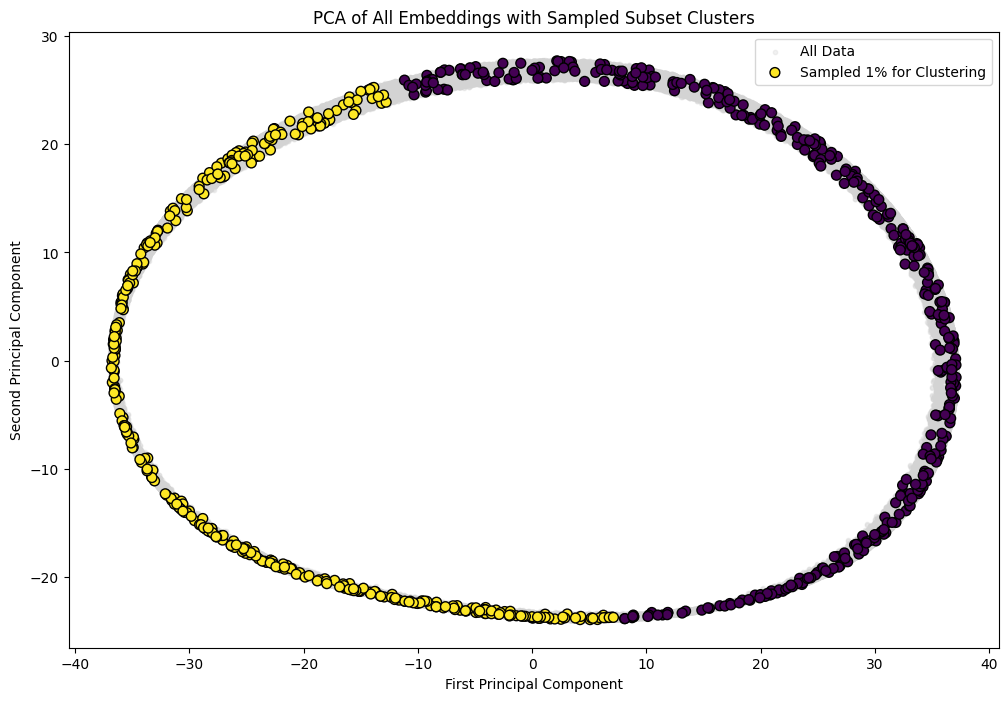

In [13]:
# Plot ALL the embeddings in PCA with Random Sampling for Clustering

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans  # Example clustering algorithm
from sklearn.model_selection import train_test_split

# ### Step 1: Prepare the Embeddings

# Reshape embeddings to ensure correct dimensions
low_pt_embeddings = low_pt_embeddings.reshape(-1, 8)   # Shape: (8000, 8)
high_pt_embeddings = high_pt_embeddings.reshape(-1, 8) # Shape: (8000, 8)

# Concatenate low and high pT embeddings
all_embeddings = np.concatenate([low_pt_embeddings, high_pt_embeddings], axis=0)  # Shape: (16000, 8)

# Perform PCA on all embeddings for visualization
pca = PCA(n_components=2)
all_embeddings_pca = pca.fit_transform(all_embeddings)  # Shape: (16000, 2)

# ### Step 2: Create the pT Mask

# Create boolean masks for low and high pT embeddings
num_low_pt = low_pt_embeddings.shape[0]    # 8000
num_high_pt = high_pt_embeddings.shape[0]  # 8000

low_pt_mask = np.ones(num_low_pt, dtype=bool)      # [True, True, ..., True] (8000,)
high_pt_mask = np.zeros(num_high_pt, dtype=bool)   # [False, False, ..., False] (8000,)
pt_mask = np.concatenate([low_pt_mask, high_pt_mask])  # Shape: (16000,)

# ### Step 3: Random Sampling (~1%) with Optional Stratification

# Define the sampling percentage
sampling_percentage = 0.01  # 1%
num_samples = int(sampling_percentage * all_embeddings.shape[0])  # 160 samples

# **Option 1: Simple Random Sampling**
# Uncomment the following lines to use simple random sampling
'''
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(all_embeddings.shape[0], size=num_samples, replace=False)
'''

# **Option 2: Stratified Random Sampling**
# Ensures proportional representation from both low and high pT embeddings
low_pt_indices = np.where(pt_mask)[0]
high_pt_indices = np.where(~pt_mask)[0]

# Calculate number of samples for each group
num_low_samples = int(sampling_percentage * num_low_pt)   # 80 samples
num_high_samples = int(sampling_percentage * num_high_pt) # 80 samples

# Randomly sample from each group
np.random.seed(42)  # For reproducibility
sampled_low_pt = np.random.choice(low_pt_indices, size=num_low_samples, replace=False)
sampled_high_pt = np.random.choice(high_pt_indices, size=num_high_samples, replace=False)

# Combine sampled indices
sample_indices = np.concatenate([sampled_low_pt, sampled_high_pt])  # Shape: (160,)

# ### Step 4: Extract the Sampled Subset

# Extract original embeddings and their PCA projections
subset_embeddings = all_embeddings[sample_indices]        # Shape: (160, 8)
subset_embeddings_pca = all_embeddings_pca[sample_indices]  # Shape: (160, 2)
subset_pt_mask = pt_mask[sample_indices]                  # Shape: (160,)

# ### Step 5: Perform Clustering in Original Embedding Space

# Initialize the clustering algorithm (spectral clustering as an example)
spectral = SpectralClustering(
    n_clusters=2, 
    affinity='nearest_neighbors', 
    assign_labels='discretize',
    n_neighbors=10,
    n_init=1,
    random_state=42,
    n_jobs=-1)
cluster_labels = spectral.fit_predict(subset_embeddings)

# ### Step 6: Visualize the Clustering Results

plt.figure(figsize=(12, 8))

# Plot all data points in light gray for context
plt.scatter(
    all_embeddings_pca[:, 0],
    all_embeddings_pca[:, 1],
    c="lightgray",
    marker='o',
    s=10,
    alpha=0.3,
    label='All Data'
)

# Overlay the sampled subset with cluster-based coloring
scatter = plt.scatter(
    subset_embeddings_pca[:, 0],
    subset_embeddings_pca[:, 1],
    c=cluster_labels,
    cmap='viridis',
    marker='o',
    s=50,
    edgecolor='k',
    label='Sampled 1% for Clustering'
)

# Add a legend
plt.legend()

# Set plot titles and labels
plt.title('PCA of All Embeddings with Sampled Subset Clusters')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Display the plot
plt.show()

## DBSCAN

Time taken: 0.04 seconds


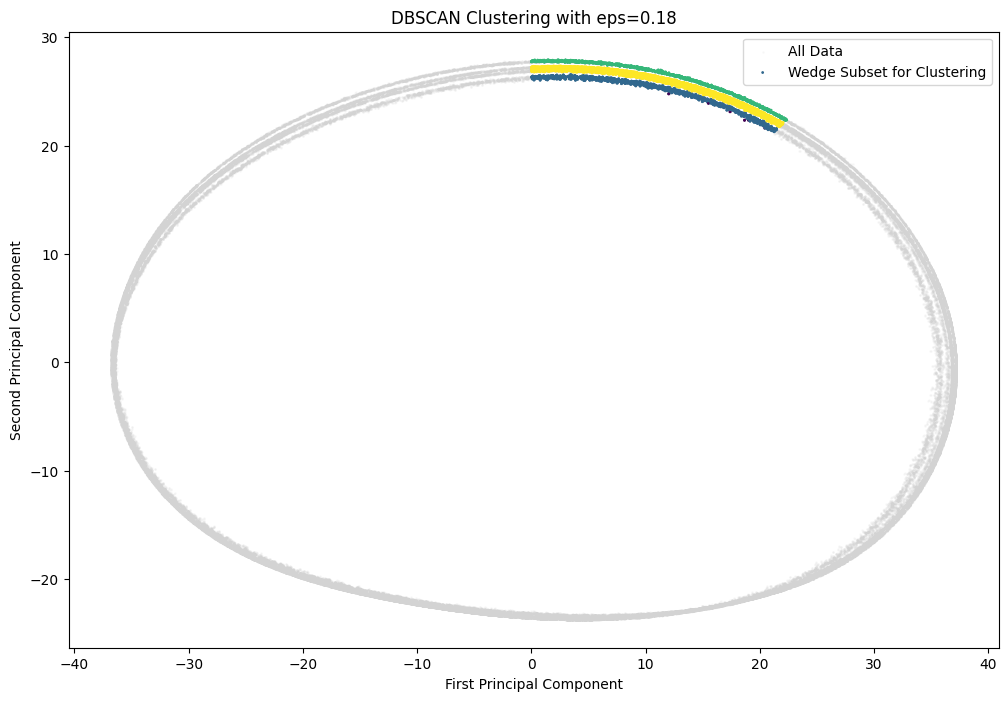

In [6]:
# Perform clustering in PCA space, using DBSCAN

from sklearn.cluster import DBSCAN

# Initialize the clustering algorithm (DBSCAN as an example)

eps = 0.18
min_samples = 10

# Add timing

# Add timing
start_time = time.time()

dbscan = DBSCAN(
    eps=eps, 
    min_samples=min_samples)
    
cluster_labels = dbscan.fit_predict(subset_embeddings_pca)

# Add timing
end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")

# Visualize the clustering results

plt.figure(figsize=(12, 8))

# Plot all data points in light gray for context
plt.scatter(
    all_embeddings_pca[:, 0],
    all_embeddings_pca[:, 1],
    c="lightgray",
    marker='o',
    s=1,
    alpha=0.1,
    label='All Data'
)

# Overlay the wedge subset with cluster-based coloring
scatter = plt.scatter(
    subset_embeddings_pca[:, 0],
    subset_embeddings_pca[:, 1],
    c=cluster_labels,
    marker='o',
    s=1,
    label='Wedge Subset for Clustering'
)

# Add a legend
plt.legend()

# Set plot titles and labels
plt.title(f'DBSCAN Clustering with eps={eps:.2f}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Display the plot
plt.show()


In [7]:
from DBCV import DBCV
from sklearn.metrics import silhouette_score

silhouette_score = silhouette_score(subset_embeddings_pca, cluster_labels)
dbsv_score = DBCV(subset_embeddings_pca, cluster_labels)

print(f"Silhouette Score: {silhouette_score:.2f}")
print(f"DBCV Score: {dbsv_score:.2f}")


KeyboardInterrupt: 

In [8]:
from dbcv import dbcv
from sklearn.metrics import silhouette_score

silhouette_score = silhouette_score(subset_embeddings_pca, cluster_labels)
dbsv_score = dbcv(subset_embeddings_pca, cluster_labels)

print(f"Silhouette Score: {silhouette_score:.2f}")
print(f"DBCV Score: {dbsv_score:.2f}")


Silhouette Score: -0.22
DBCV Score: -0.21


Time taken: 0.03 seconds


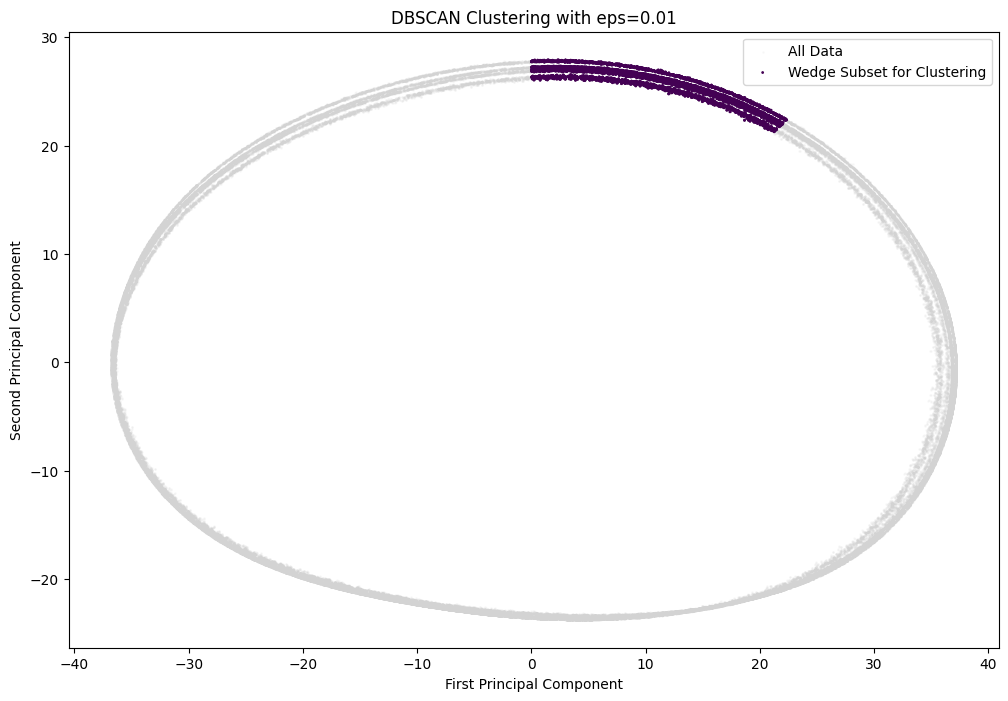

Time taken: 0.03 seconds


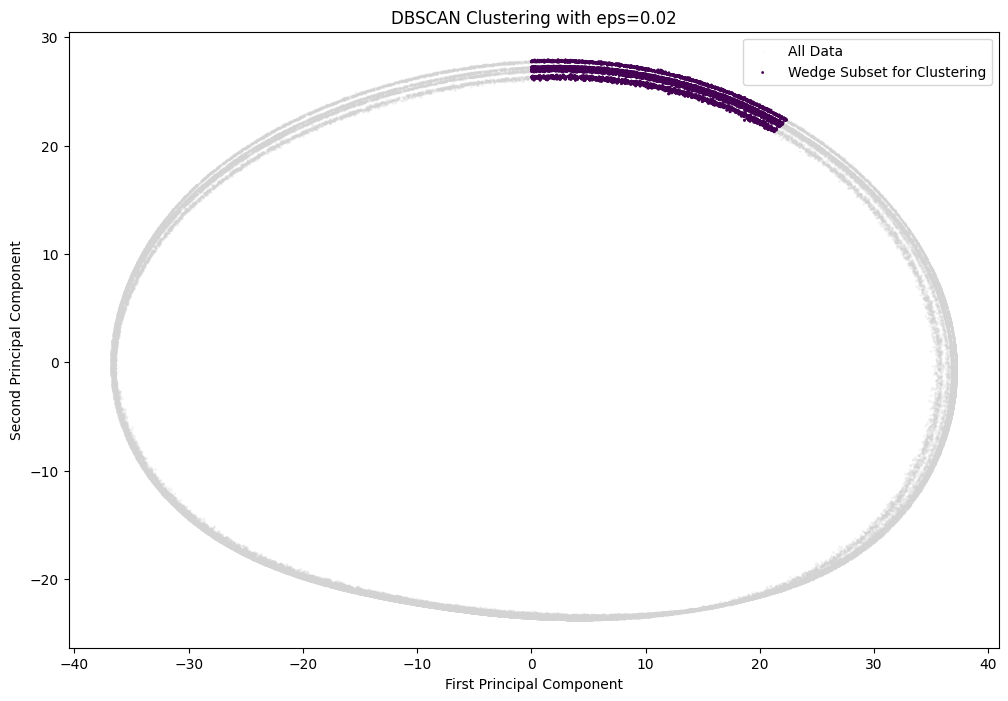

Time taken: 0.03 seconds


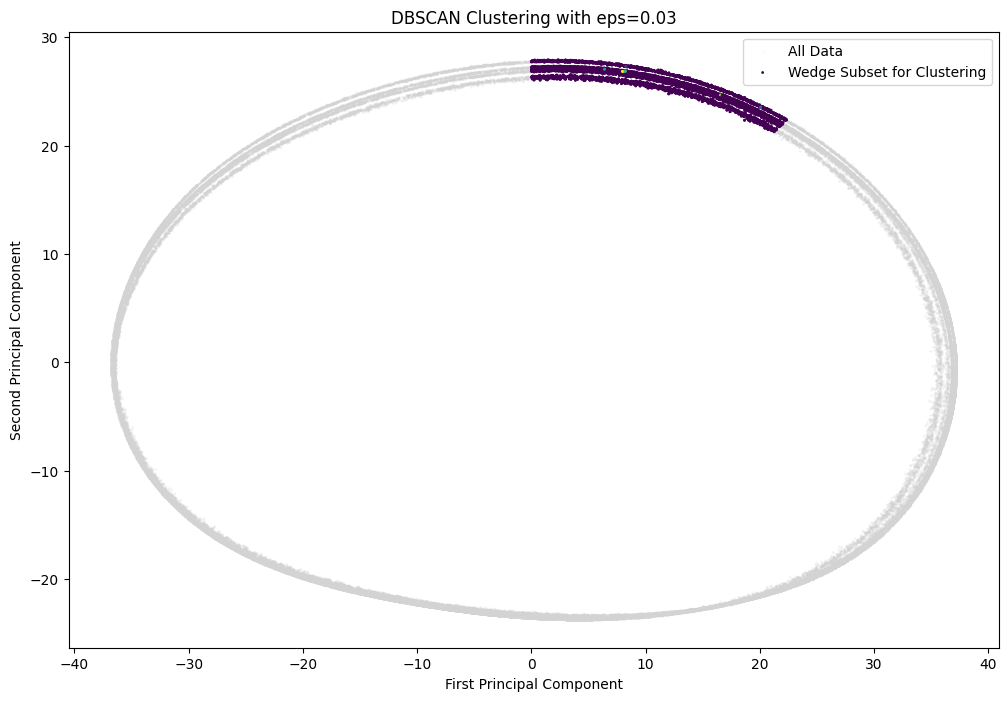

Time taken: 0.03 seconds


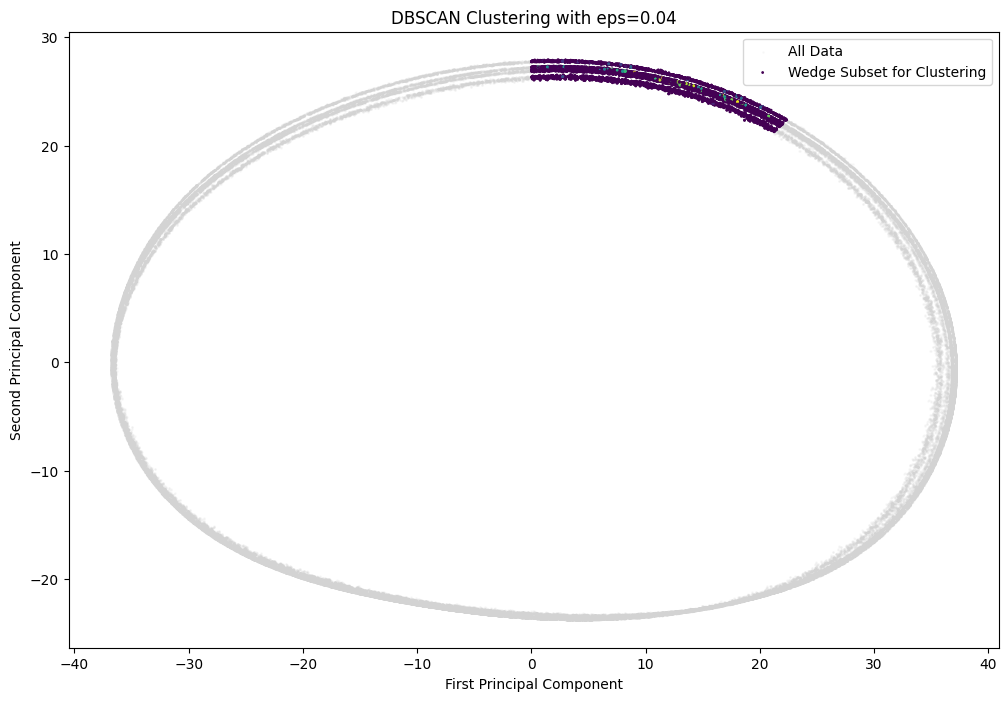

Time taken: 0.03 seconds


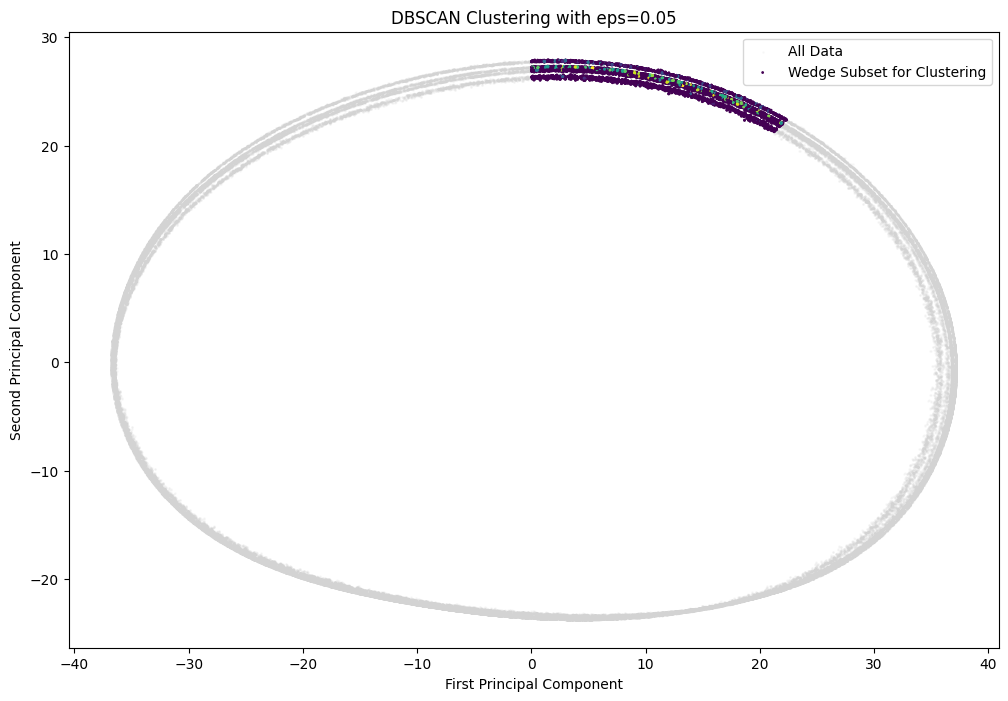

Time taken: 0.03 seconds


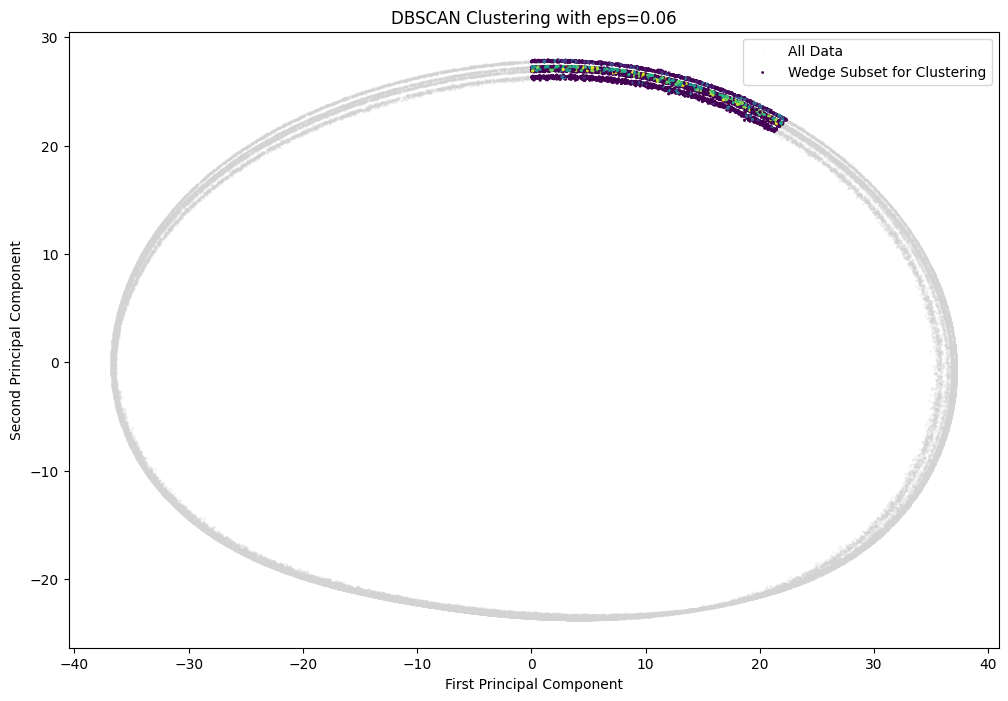

Time taken: 0.03 seconds


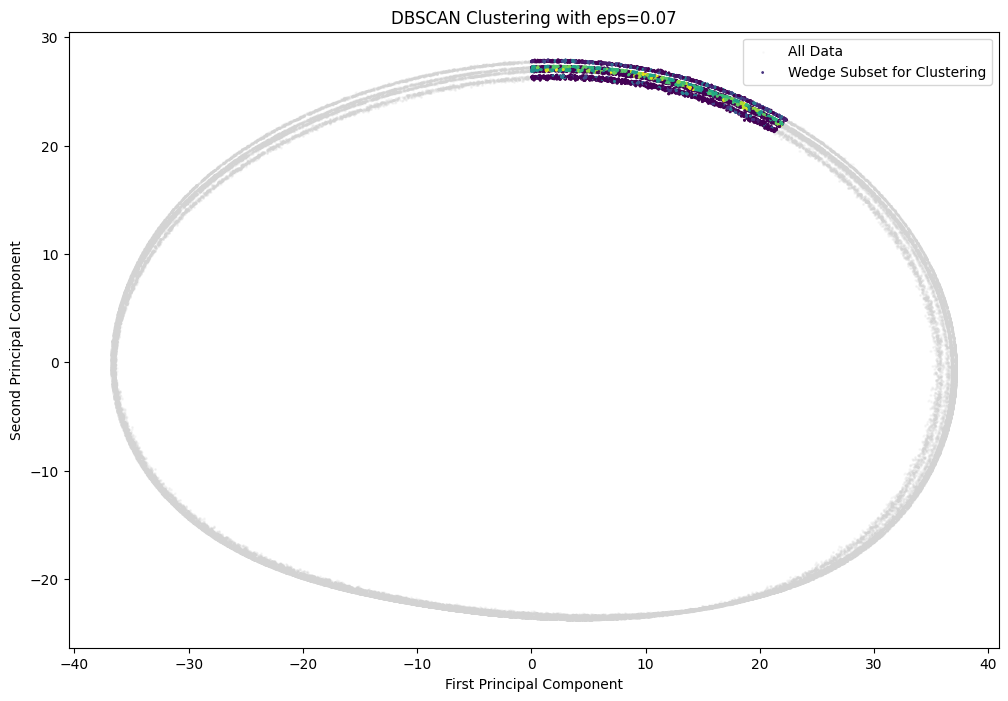

Time taken: 0.03 seconds


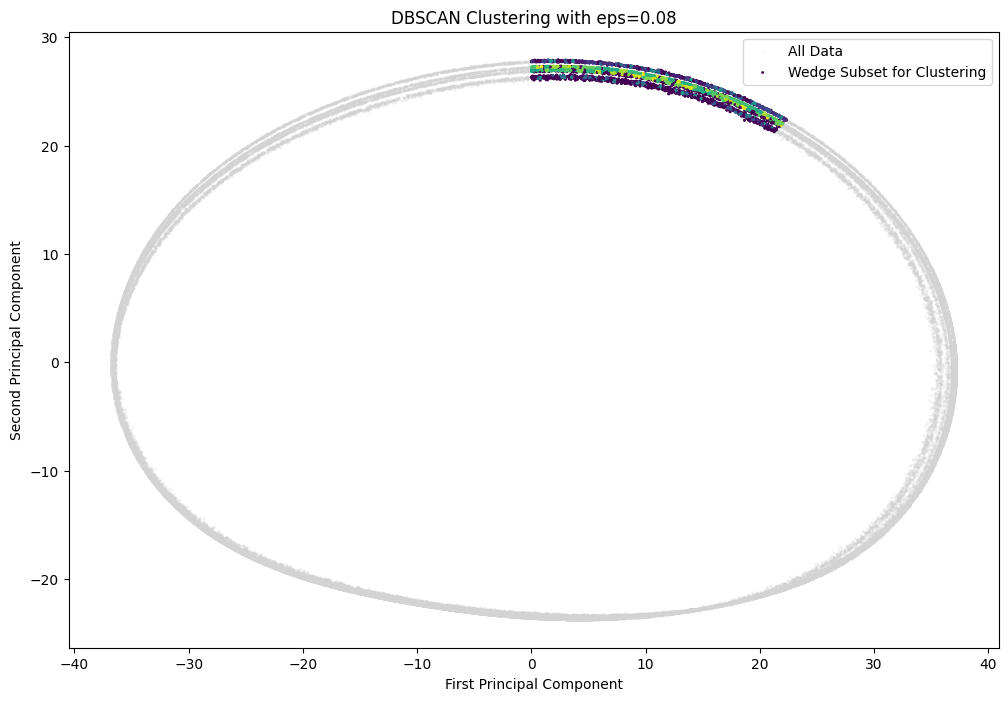

Time taken: 0.03 seconds


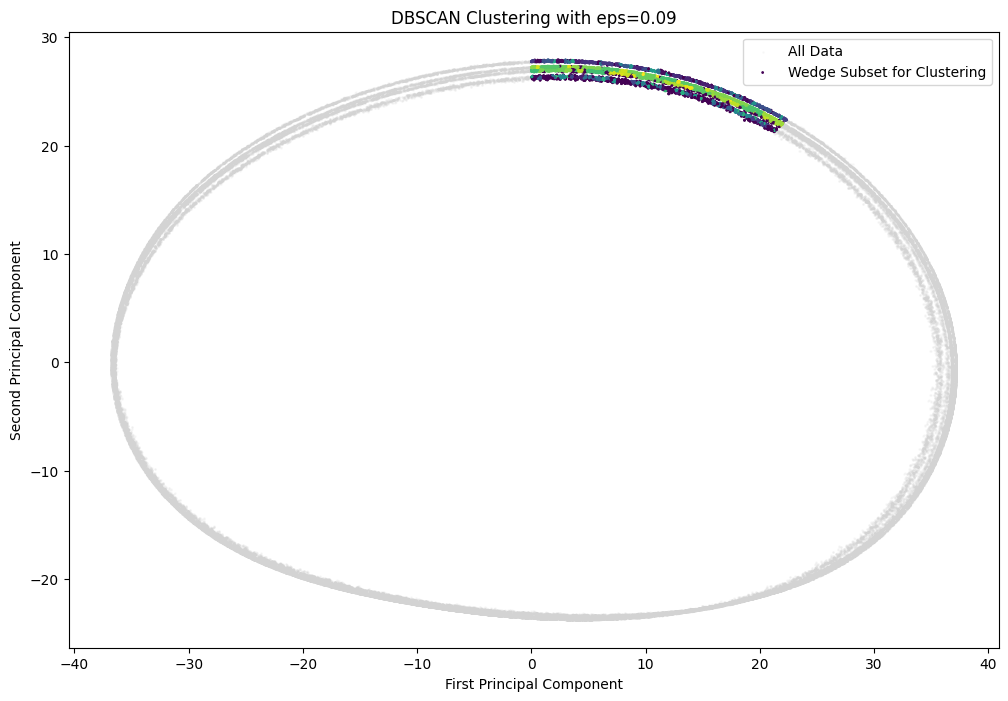

Time taken: 0.03 seconds


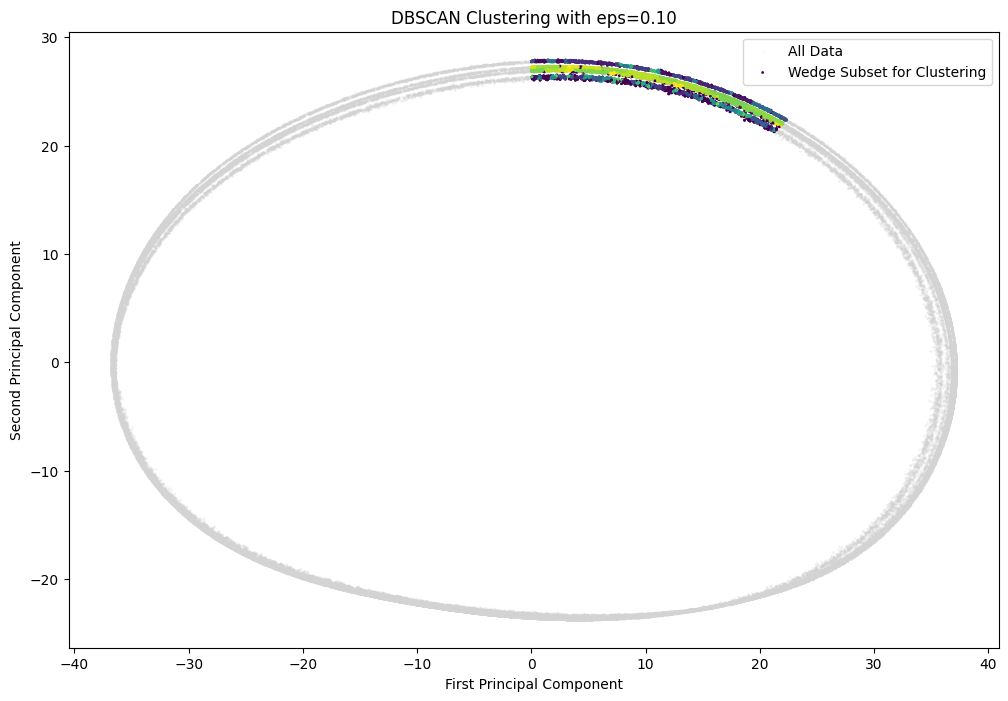

Time taken: 0.03 seconds


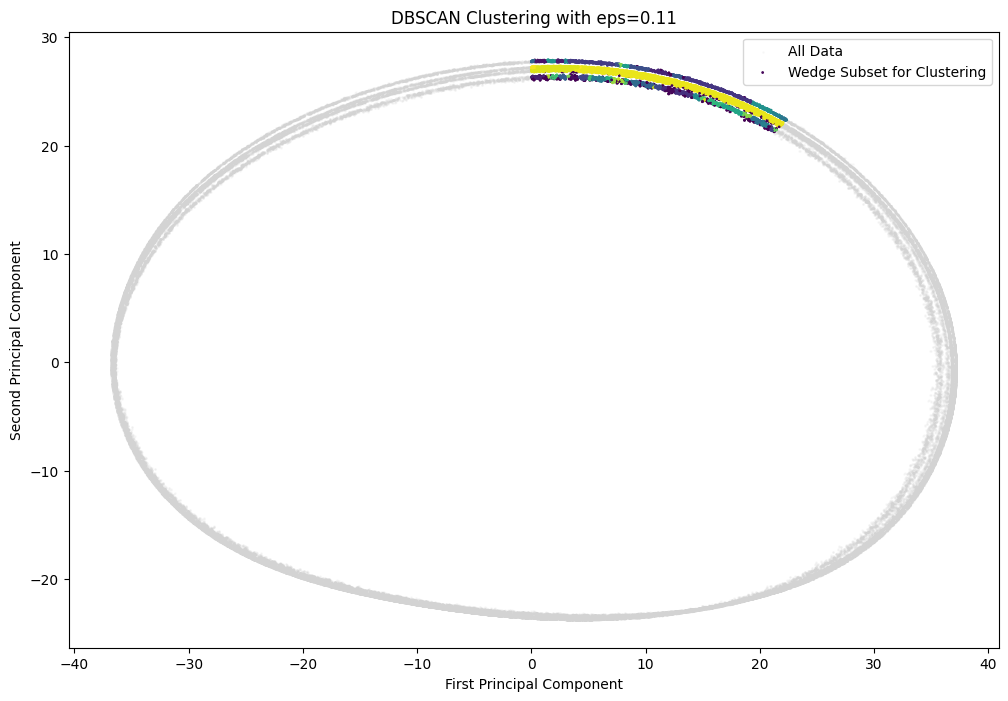

Time taken: 0.03 seconds


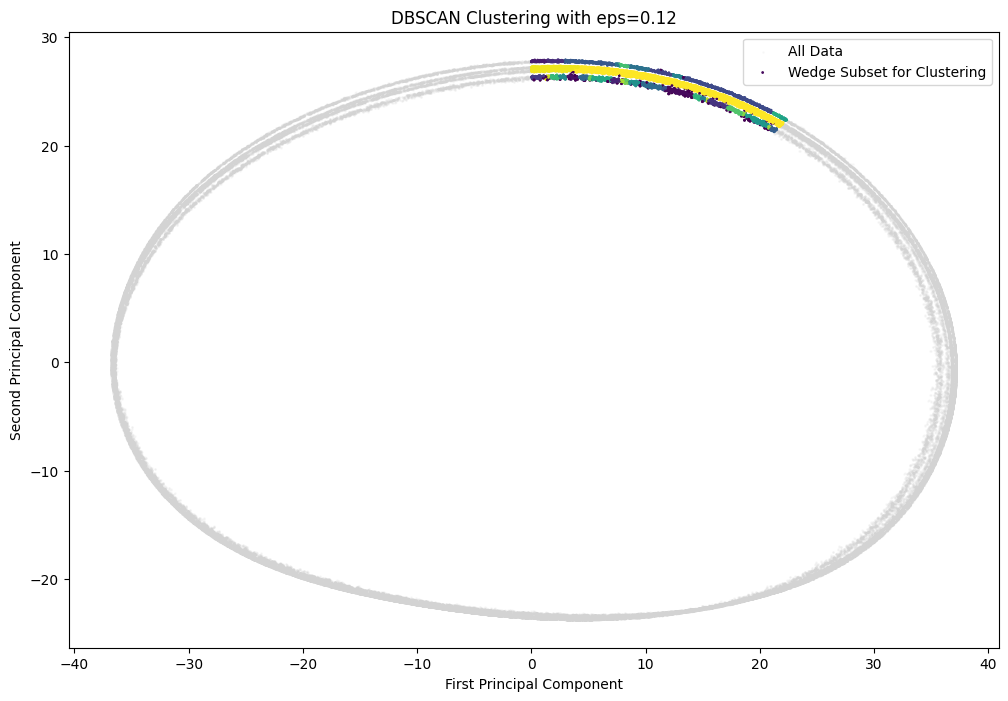

Time taken: 0.04 seconds


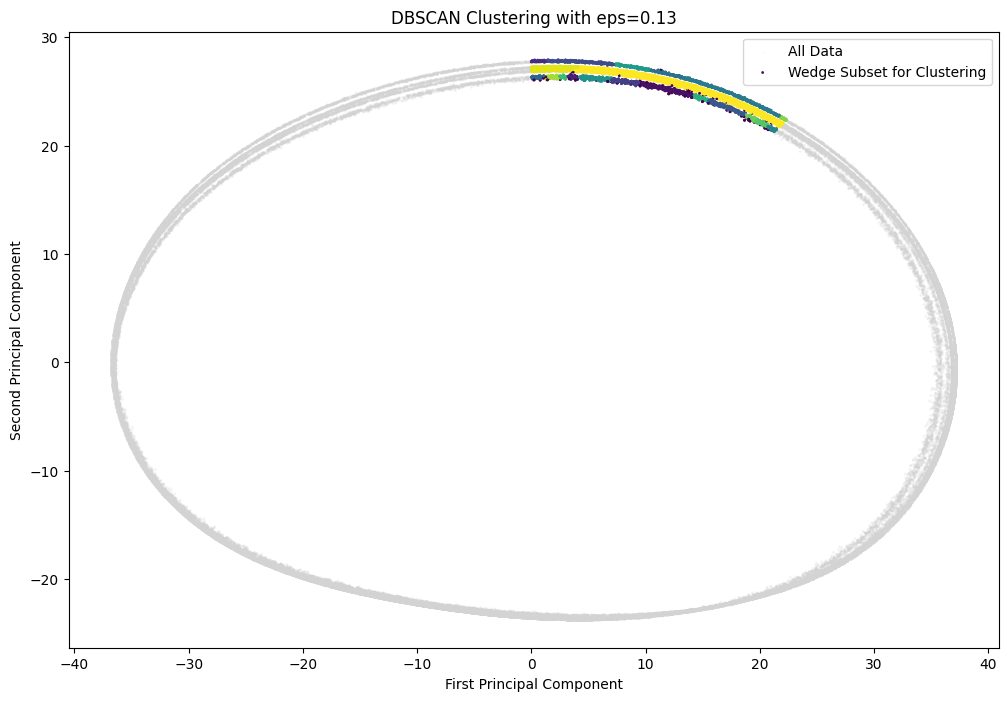

Time taken: 0.04 seconds


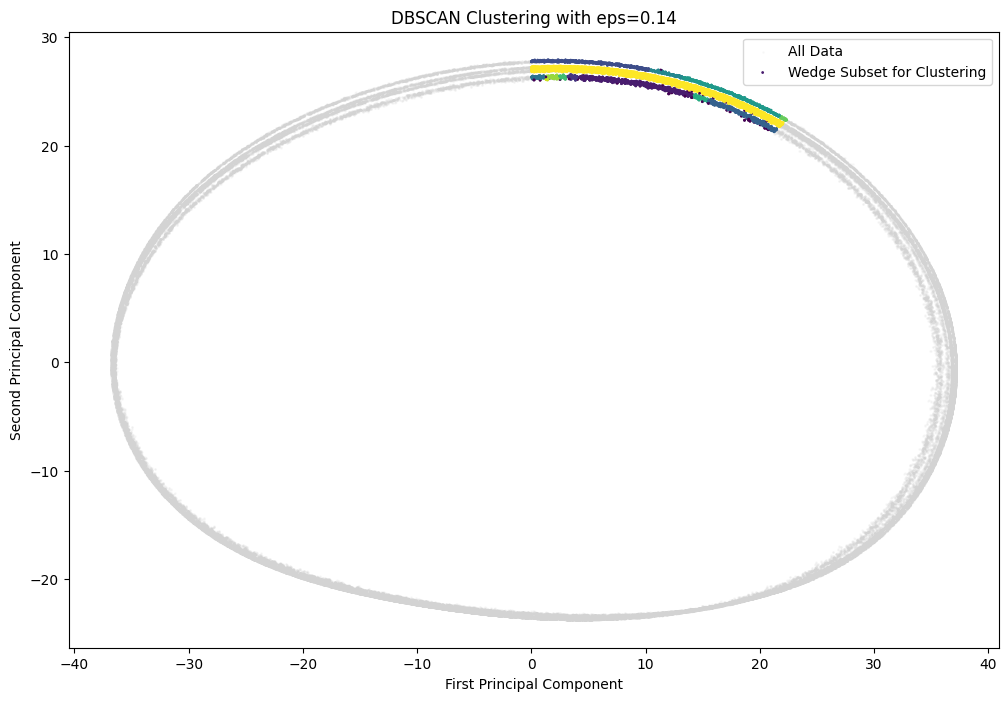

Time taken: 0.04 seconds


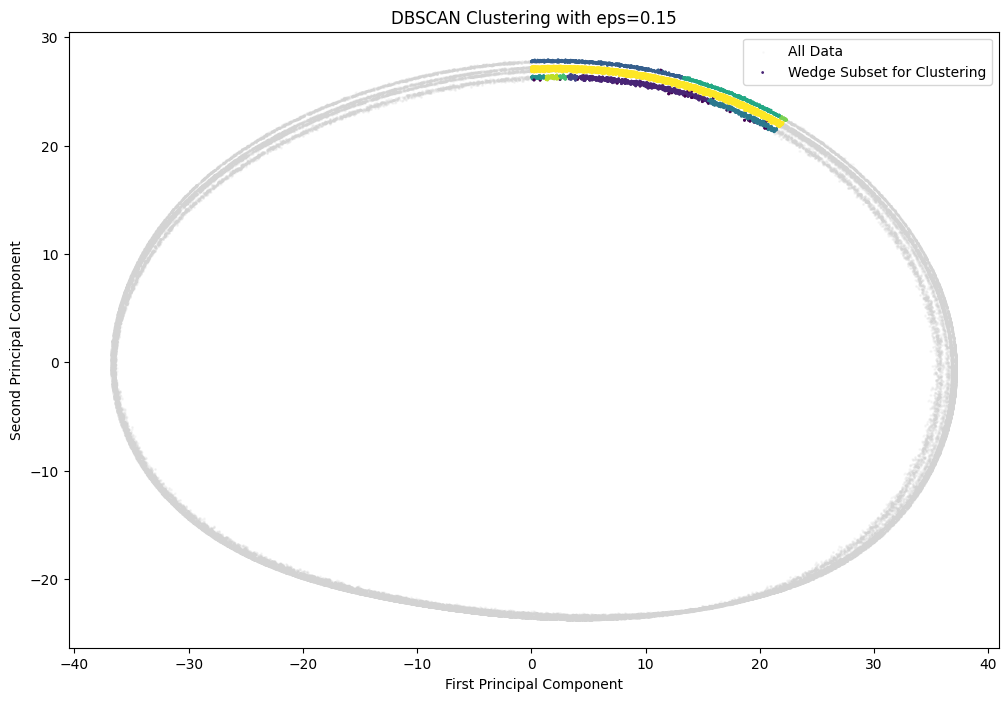

Time taken: 0.04 seconds


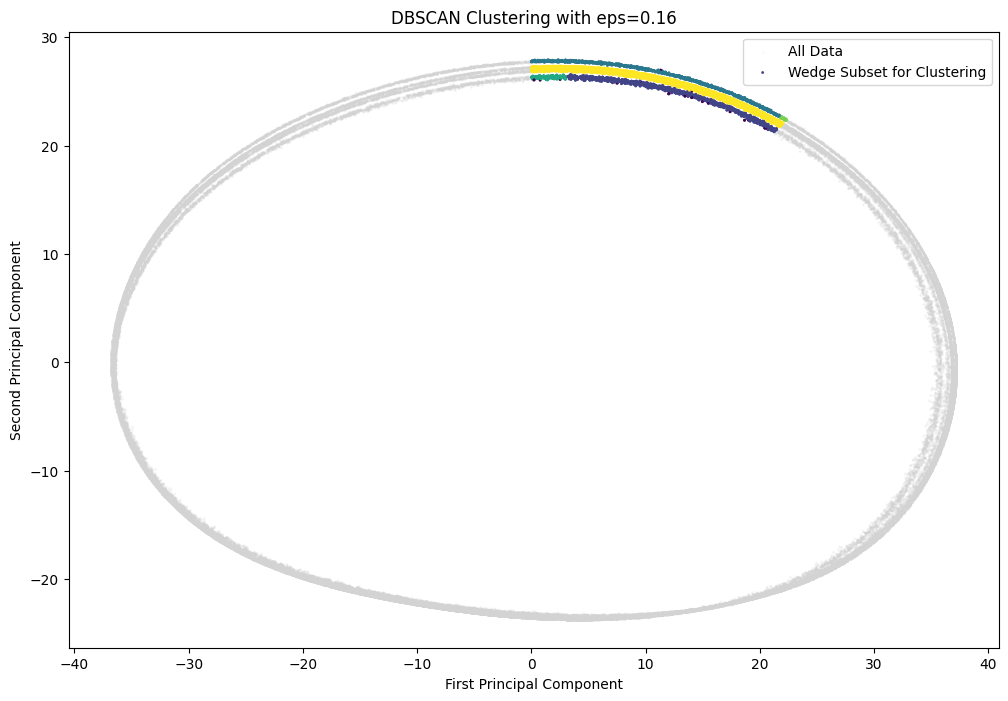

Time taken: 0.04 seconds


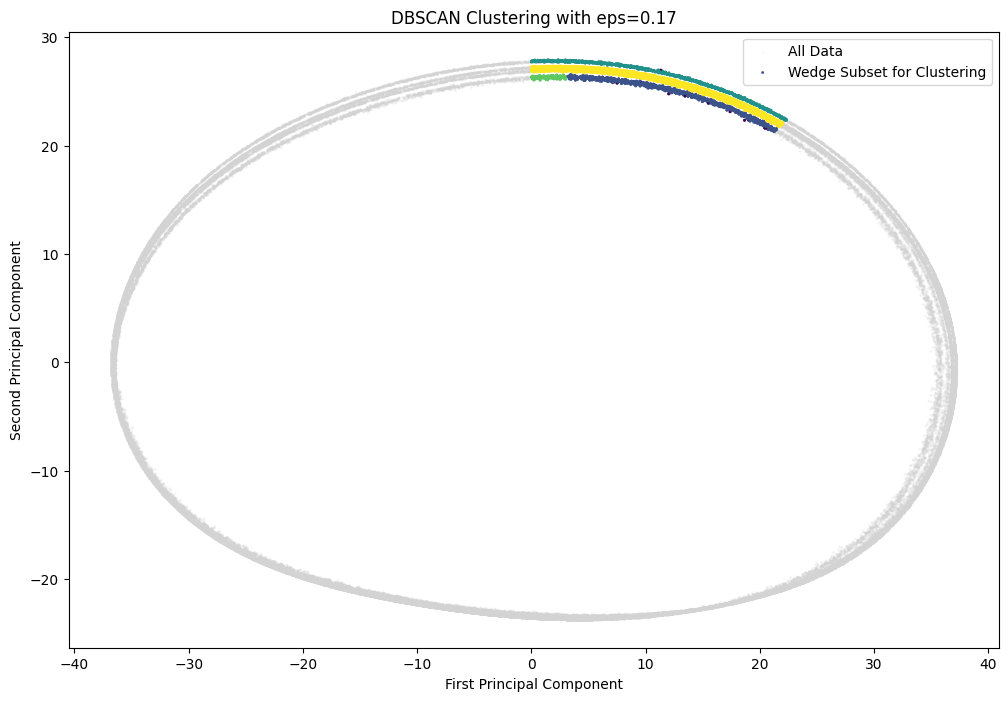

Time taken: 0.04 seconds


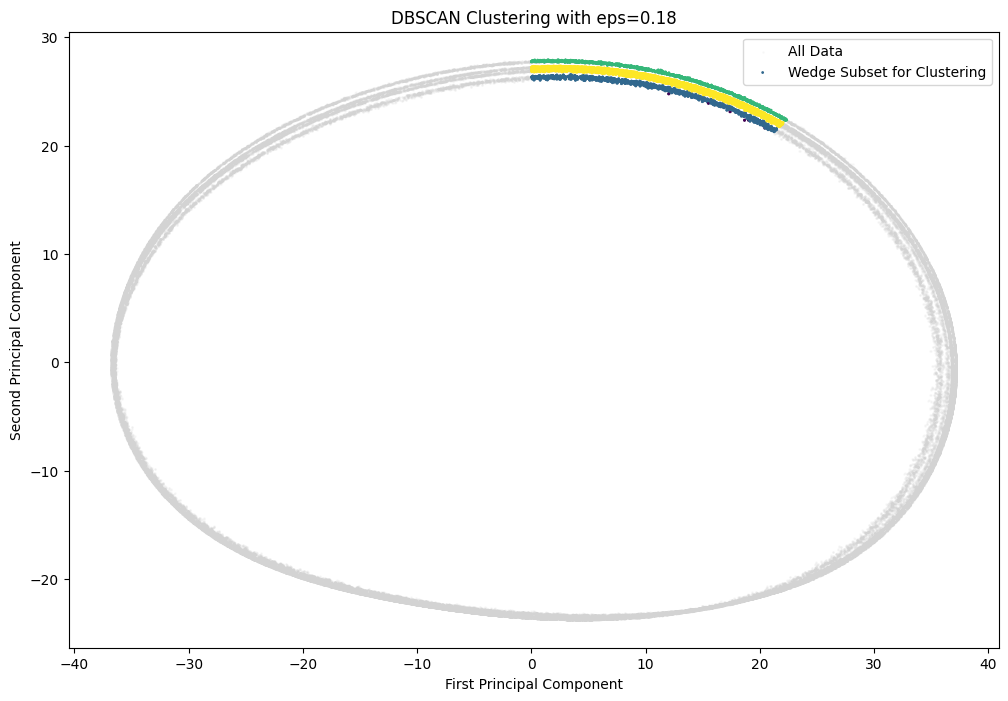

Time taken: 0.04 seconds


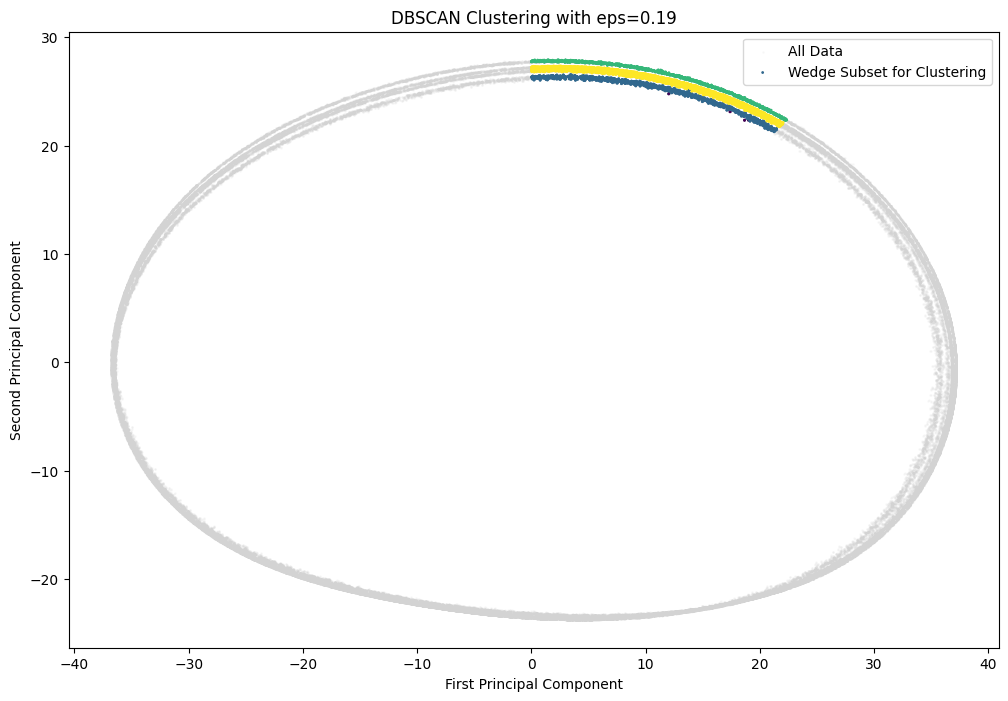

Time taken: 0.04 seconds


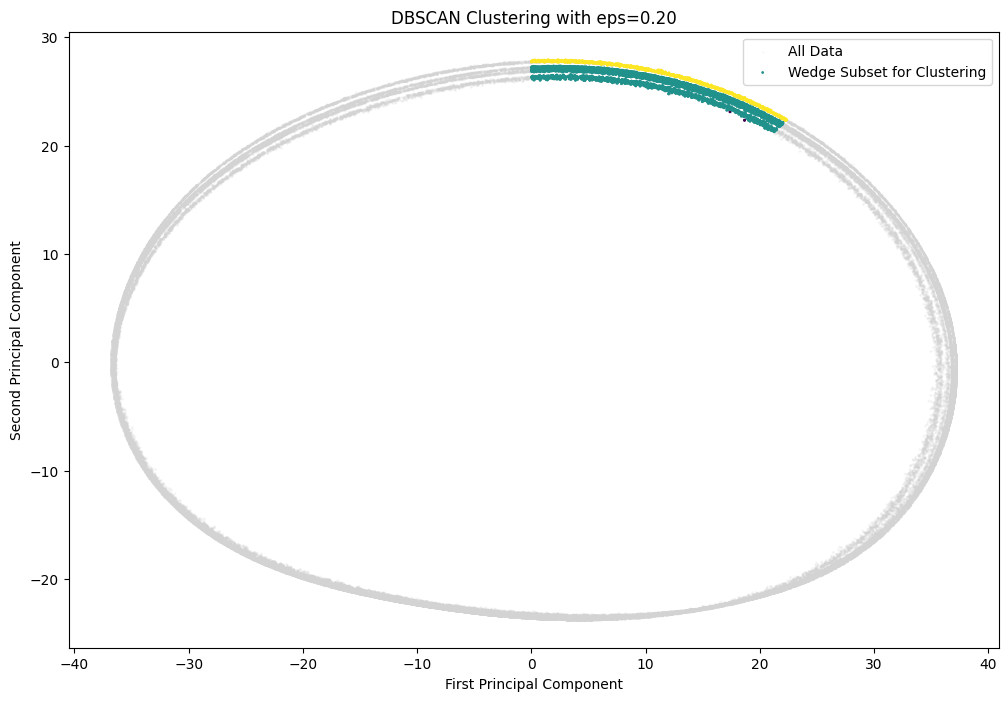

In [48]:
# Perform clustering in PCA space, using DBSCAN

from sklearn.cluster import DBSCAN

# Initialize the clustering algorithm (DBSCAN as an example)

eps_list = np.linspace(0.01, 0.2, 20)

for eps in eps_list:

    # Add timing
    start_time = time.time()

    dbscan = DBSCAN(
        eps=eps, 
        min_samples=10)
        
    cluster_labels = dbscan.fit_predict(subset_embeddings_pca)

    # Add timing
    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Visualize the clustering results

    plt.figure(figsize=(12, 8))

    # Plot all data points in light gray for context
    plt.scatter(
        all_embeddings_pca[:, 0],
        all_embeddings_pca[:, 1],
        c="lightgray",
        marker='o',
        s=1,
        alpha=0.1,
        label='All Data'
    )

    # Overlay the wedge subset with cluster-based coloring
    scatter = plt.scatter(
        subset_embeddings_pca[:, 0],
        subset_embeddings_pca[:, 1],
        c=cluster_labels,
        marker='o',
        s=1,
        label='Wedge Subset for Clustering'
    )

    # Add a legend
    plt.legend()

    # Set plot titles and labels
    plt.title(f'DBSCAN Clustering with eps={eps:.2f}')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')

    # Display the plot
    plt.show()


Time taken: 0.04 seconds


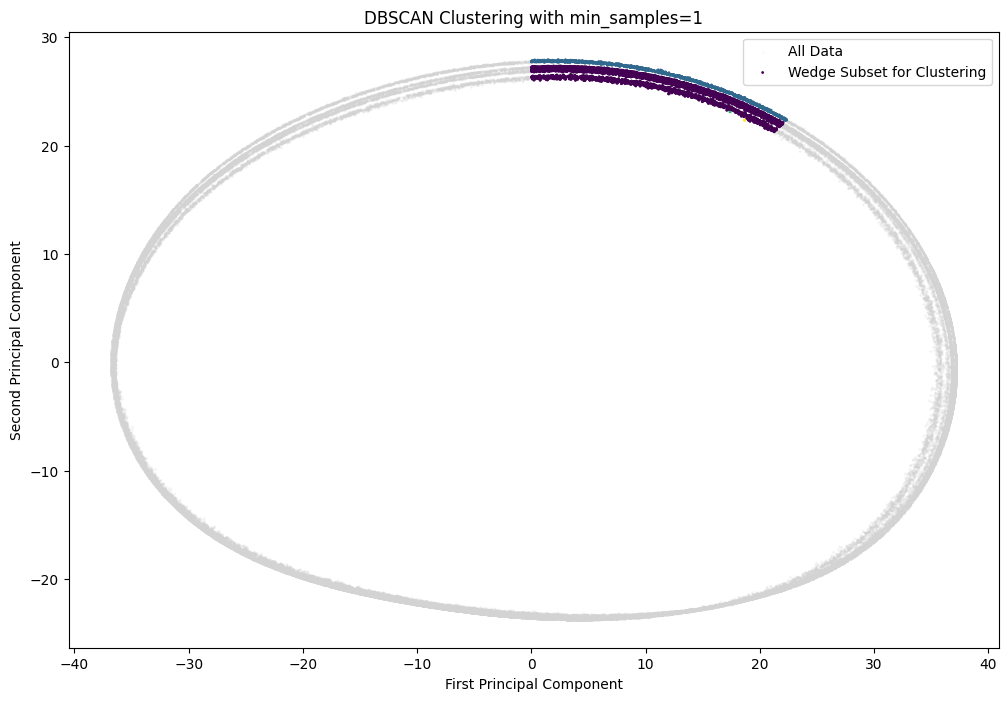

Time taken: 0.04 seconds


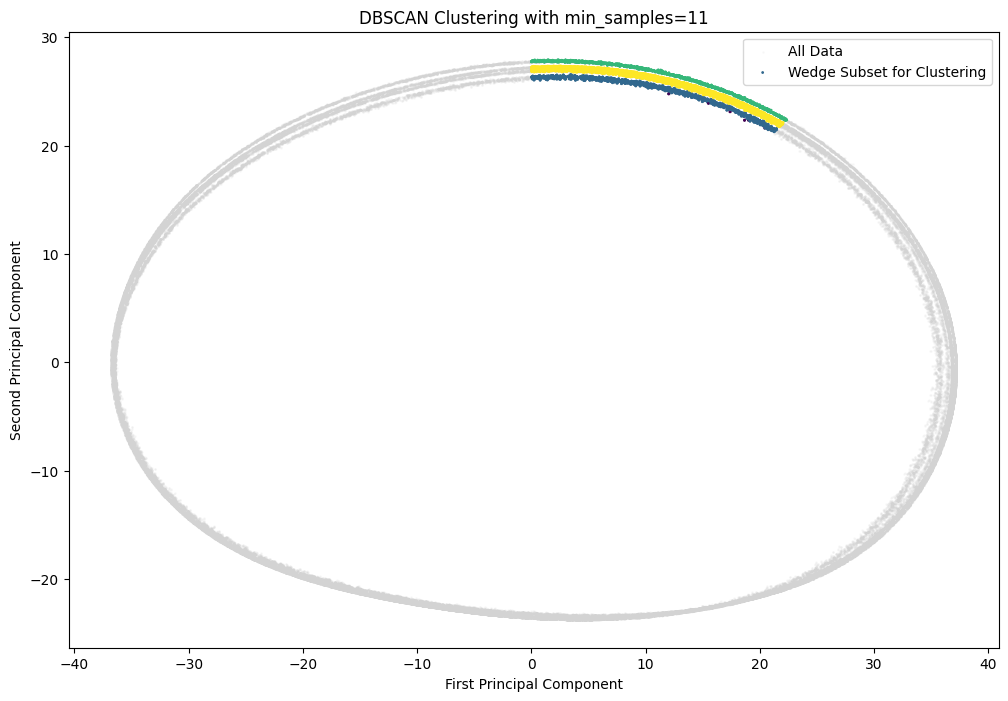

Time taken: 0.04 seconds


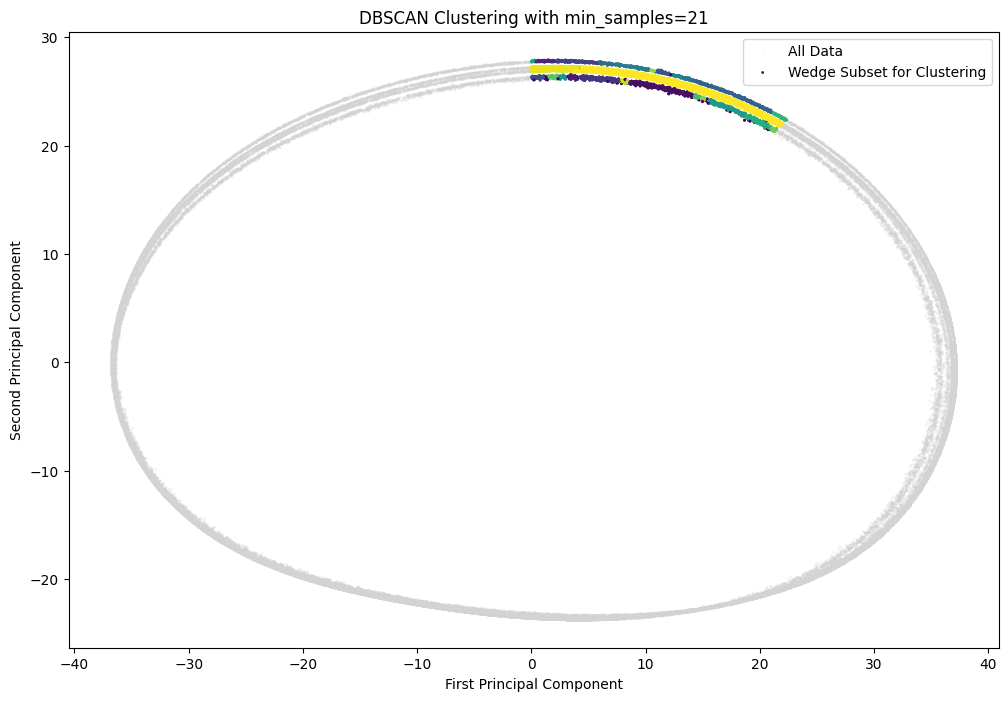

Time taken: 0.04 seconds


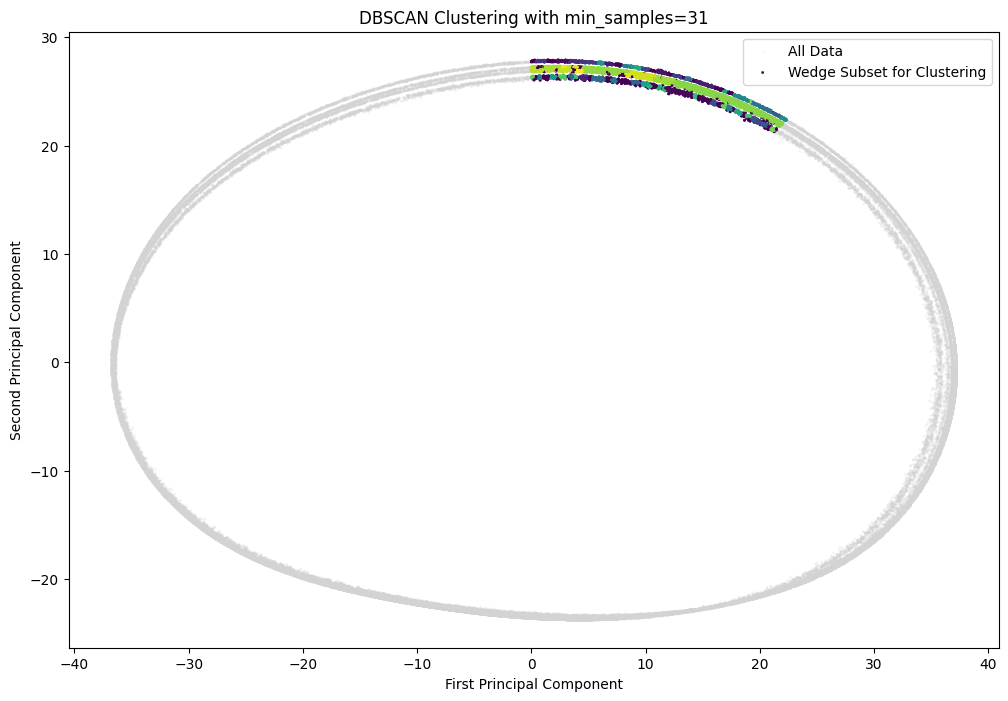

Time taken: 0.04 seconds


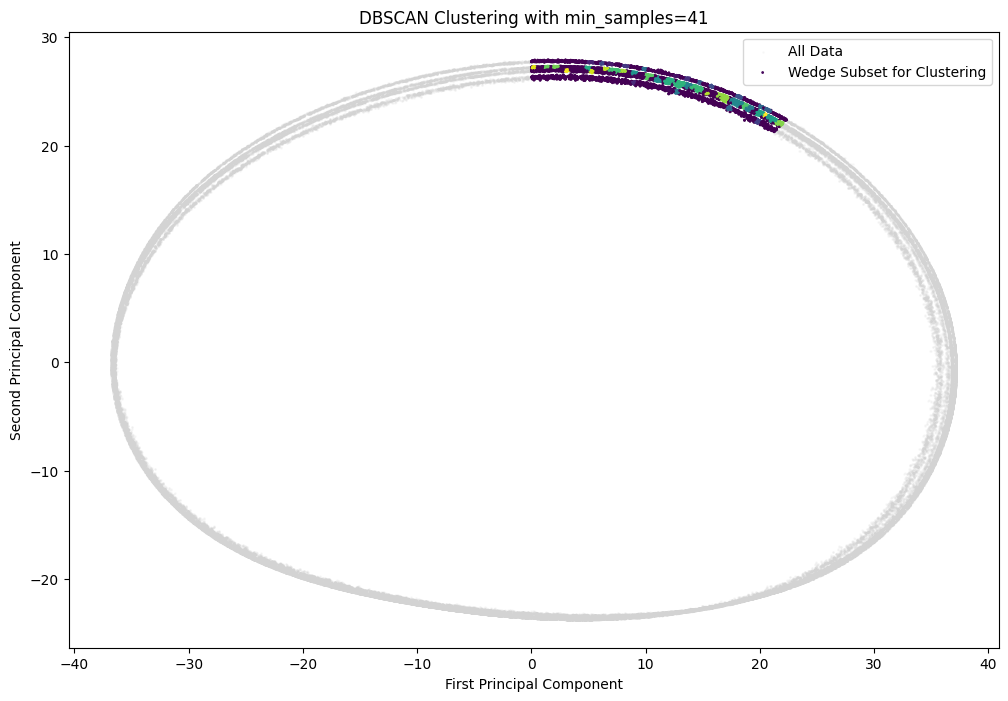

Time taken: 0.04 seconds


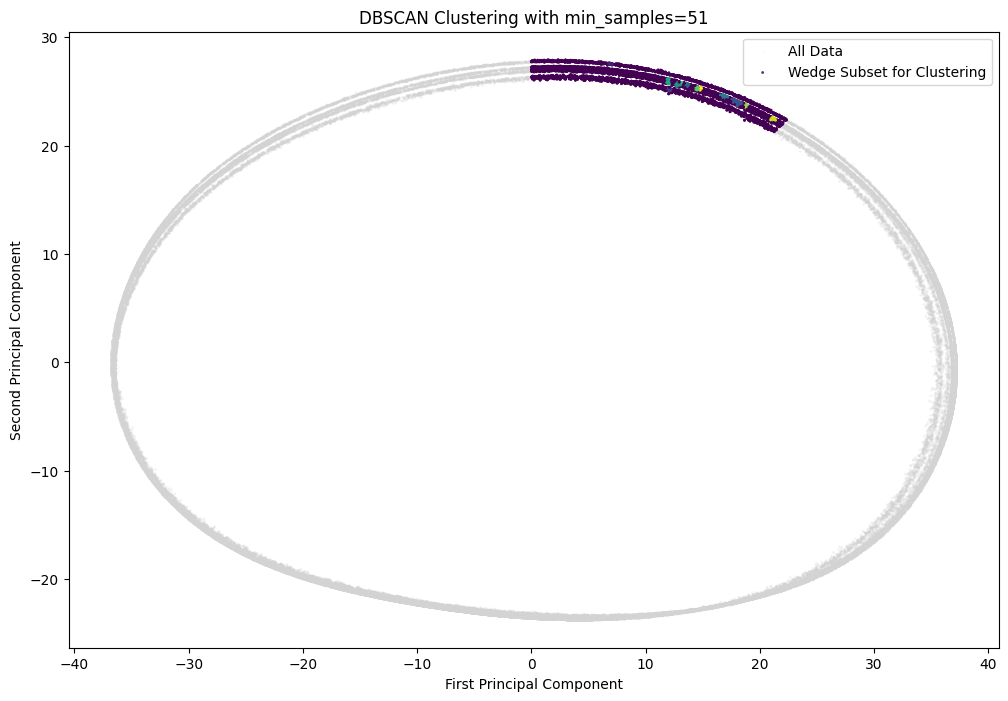

Time taken: 0.04 seconds


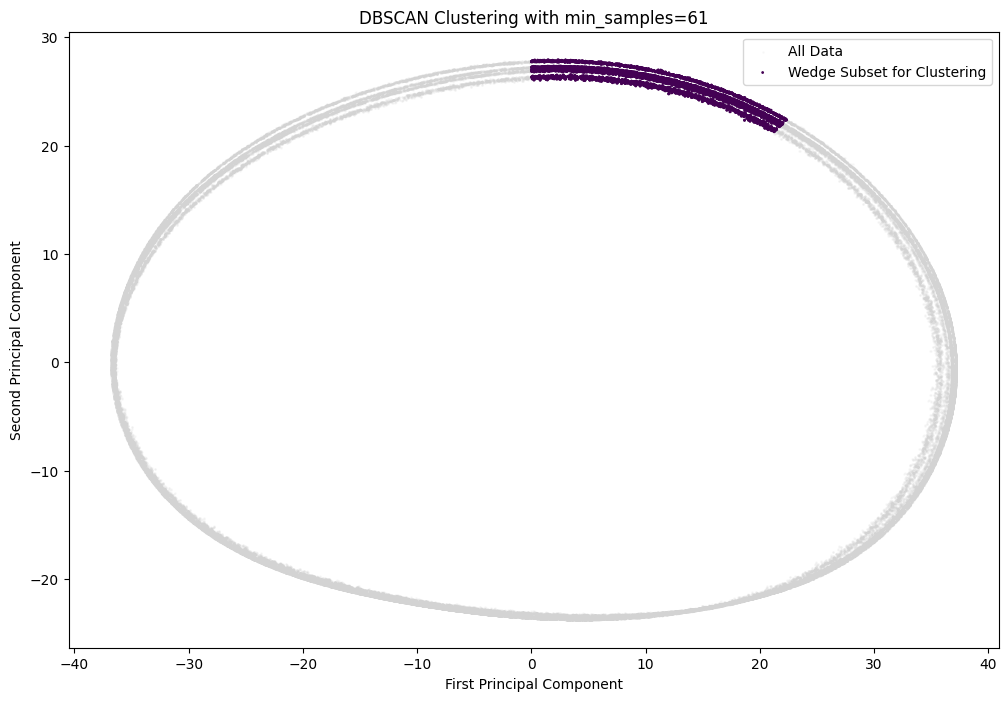

Time taken: 0.04 seconds


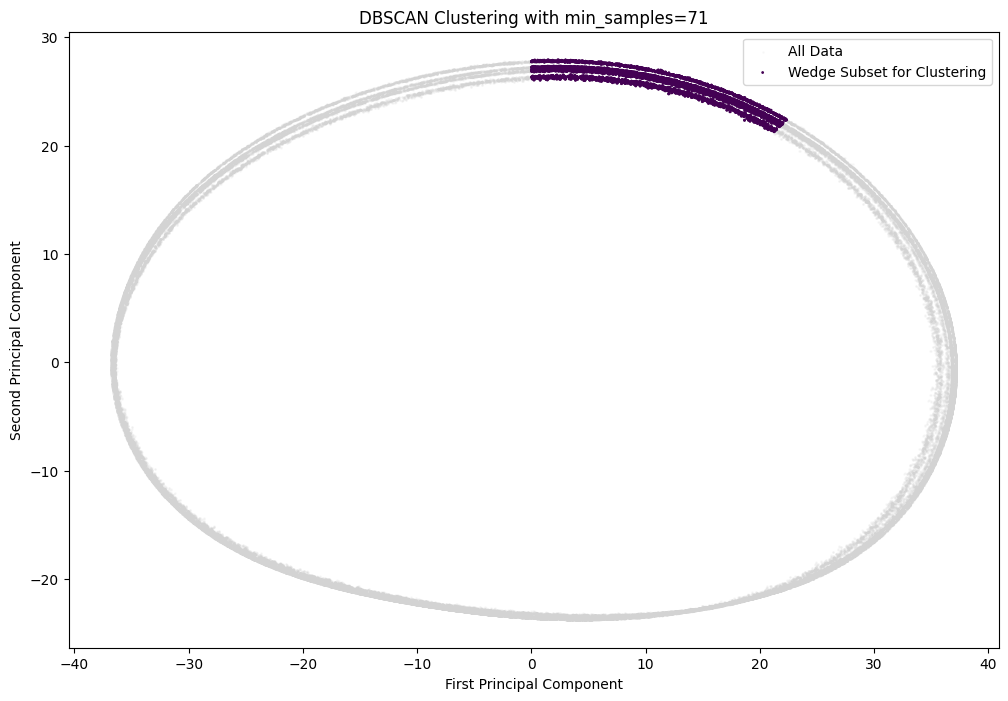

Time taken: 0.04 seconds


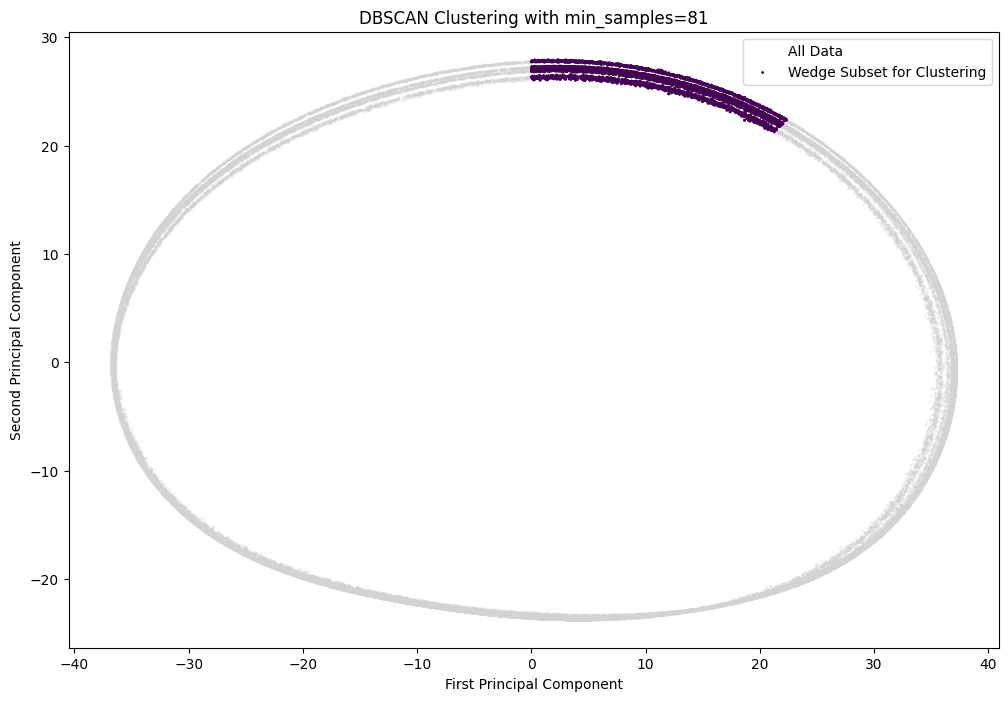

Time taken: 0.04 seconds


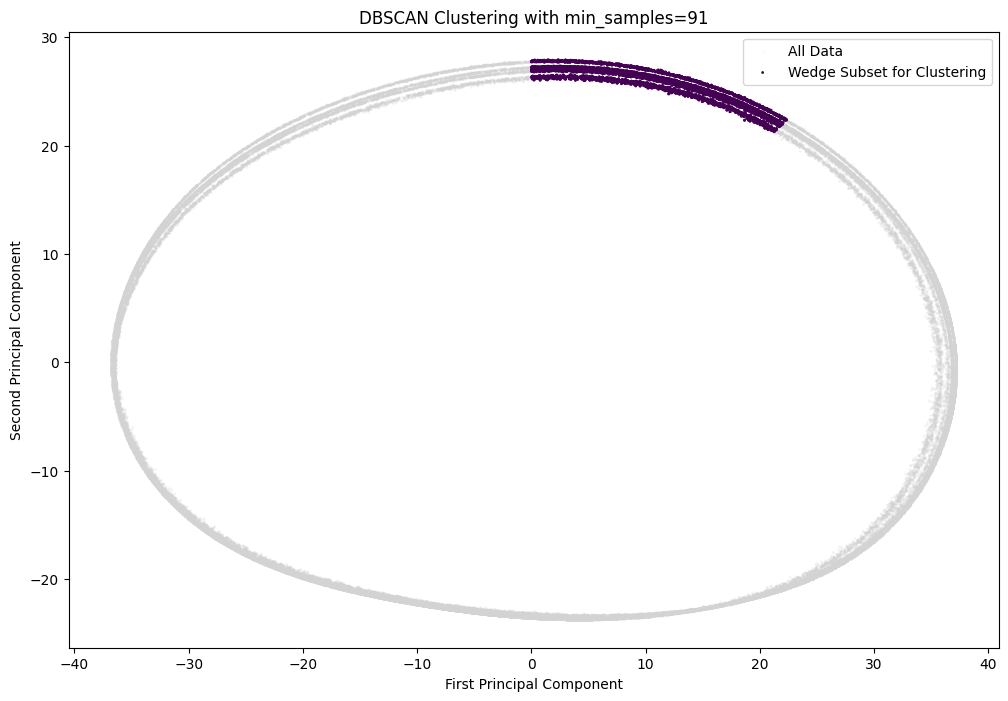

In [49]:
# Perform clustering in PCA space, using DBSCAN

from sklearn.cluster import DBSCAN

# Initialize the clustering algorithm (DBSCAN as an example)

eps = 0.18
min_sample_list = np.arange(1, 100, 10)

for min_samples in min_sample_list:

    # Add timing
    start_time = time.time()

    dbscan = DBSCAN(
        eps=eps, 
        min_samples=min_samples)
        
    cluster_labels = dbscan.fit_predict(subset_embeddings_pca)

    # Add timing
    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Visualize the clustering results

    plt.figure(figsize=(12, 8))

    # Plot all data points in light gray for context
    plt.scatter(
        all_embeddings_pca[:, 0],
        all_embeddings_pca[:, 1],
        c="lightgray",
        marker='o',
        s=1,
        alpha=0.1,
        label='All Data'
    )

    # Overlay the wedge subset with cluster-based coloring
    scatter = plt.scatter(
        subset_embeddings_pca[:, 0],
        subset_embeddings_pca[:, 1],
        c=cluster_labels,
        marker='o',
        s=1,
        label='Wedge Subset for Clustering'
    )

    # Add a legend
    plt.legend()

    # Set plot titles and labels
    plt.title(f'DBSCAN Clustering with min_samples={min_samples}')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')

    # Display the plot
    plt.show()


5it [01:59, 23.92s/it]


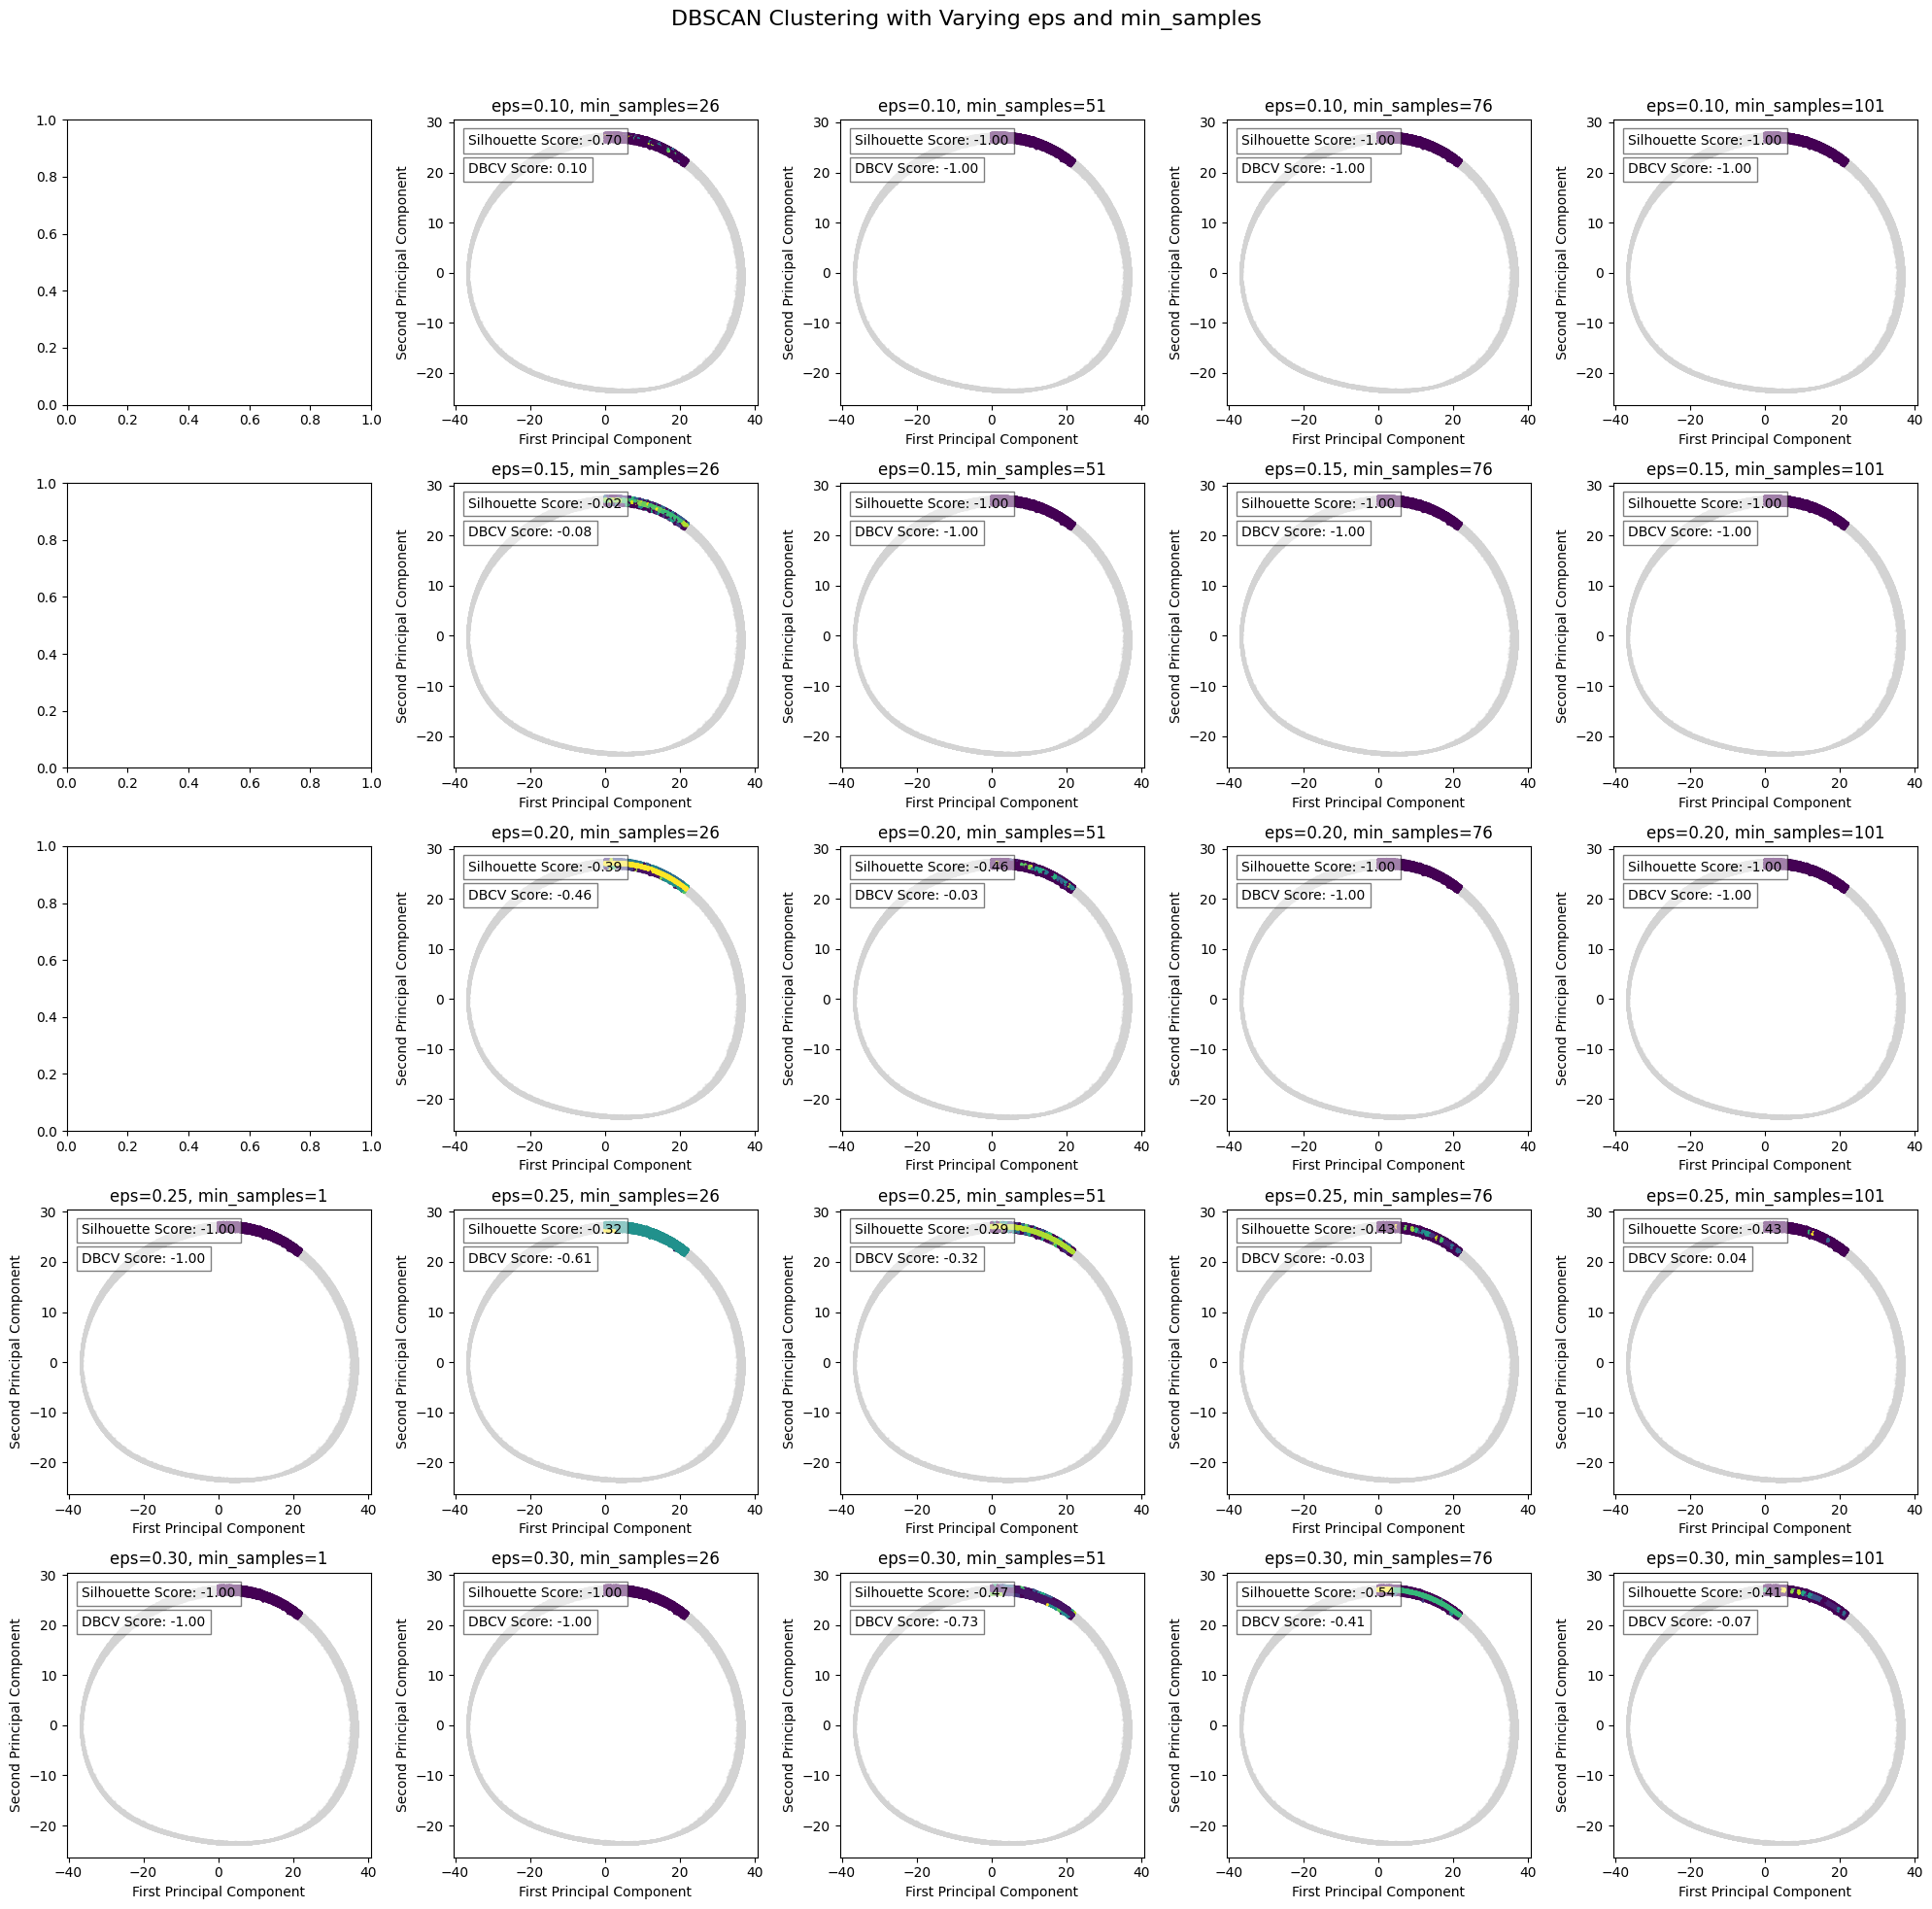

In [11]:
# Perform clustering in PCA space, using DBSCAN, and printing out silhouette score

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from dbcv import dbcv
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

# Initialize the range for eps and min_samples
eps_list = np.linspace(0.1, 0.3, 5)
min_sample_list = np.linspace(1, 101, 5)

# Create a grid of subplots
fig, axes = plt.subplots(len(eps_list), len(min_sample_list), figsize=(20, 20))
fig.suptitle('DBSCAN Clustering with Varying eps and min_samples', fontsize=16)

# Loop over eps and min_samples
for i, eps in tqdm(enumerate(eps_list)):
    for j, min_samples in enumerate(min_sample_list):

        try:
            # Add timing
            start_time = time.time()

            dbscan = DBSCAN(eps=eps, min_samples=int(min_samples))
            cluster_labels = dbscan.fit_predict(subset_embeddings_pca)
            silhouette_avg = silhouette_score(subset_embeddings_pca, cluster_labels) if len(set(cluster_labels)) > 1 else -1
            dbsv_score = dbcv(subset_embeddings_pca, cluster_labels) if len(set(cluster_labels)) > 1 else -1
            # Add timing
            end_time = time.time()
            # print(f"eps={eps:.2f}, min_samples={min_samples}, Time taken: {end_time - start_time:.2f} seconds")

            # Visualize the clustering results
            ax = axes[i, j]
            ax.scatter(
                all_embeddings_pca[:, 0],
                all_embeddings_pca[:, 1],
                c="lightgray",
                marker='o',
                s=1,
                alpha=0.1,
                label='All Data'
            )
            scatter = ax.scatter(
                subset_embeddings_pca[:, 0],
                subset_embeddings_pca[:, 1],
                c=cluster_labels,
                marker='o',
                s=1,
                label='Wedge Subset for Clustering'
            )
            ax.set_title(f'eps={eps:.2f}, min_samples={int(min_samples)}')
            # Puts scores inside the plot
            ax.text(0.05, 0.95, f'Silhouette Score: {silhouette_avg:.2f}', transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
            ax.text(0.05, 0.85, f'DBCV Score: {dbsv_score:.2f}', transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
            ax.set_xlabel('First Principal Component')
            ax.set_ylabel('Second Principal Component')
        except:
            pass

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## HDBSCAN

Time taken: 0.35 seconds


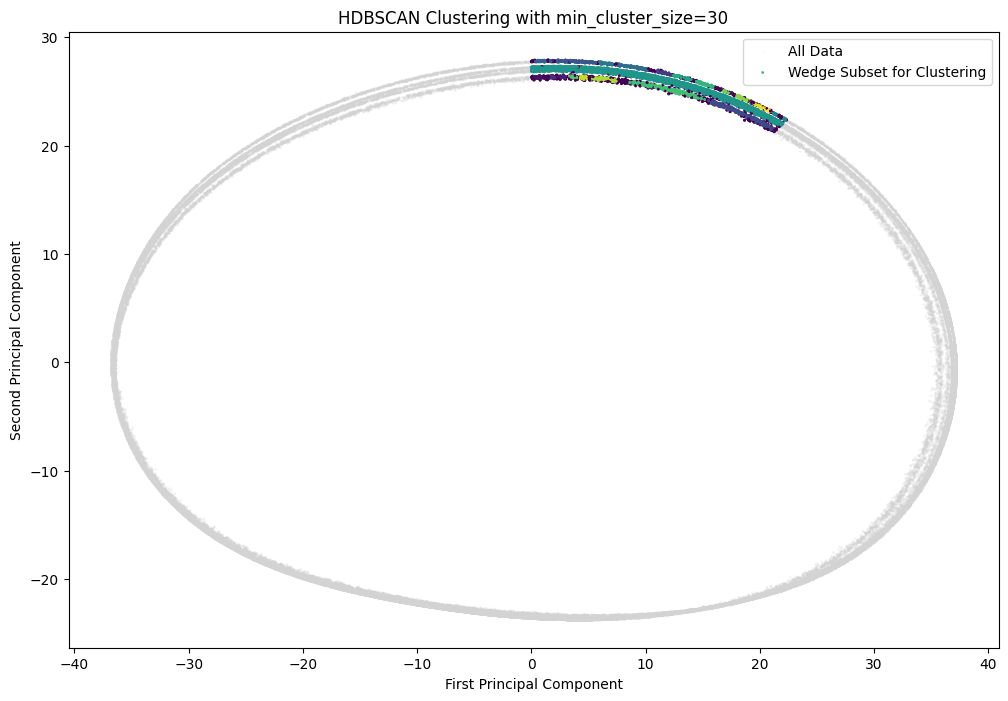

In [18]:
# Perform clustering in PCA space, using HDBSCAN

from sklearn.cluster import HDBSCAN

# Initialize the clustering algorithm (HDBSCAN as an example)

min_cluster_size = 30

# Add timing

# Add timing
start_time = time.time()

hdbscan = HDBSCAN(
    min_cluster_size=min_cluster_size)
    
cluster_labels = hdbscan.fit_predict(subset_embeddings_pca)

# Add timing
end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")

# Visualize the clustering results

plt.figure(figsize=(12, 8))

# Plot all data points in light gray for context
plt.scatter(
    all_embeddings_pca[:, 0],
    all_embeddings_pca[:, 1],
    c="lightgray",
    marker='o',
    s=1,
    alpha=0.1,
    label='All Data'
)

# Overlay the wedge subset with cluster-based coloring
scatter = plt.scatter(
    subset_embeddings_pca[:, 0],
    subset_embeddings_pca[:, 1],
    c=cluster_labels,
    marker='o',
    s=1,
    label='Wedge Subset for Clustering'
)

# Add a legend
plt.legend()

# Set plot titles and labels
plt.title(f'HDBSCAN Clustering with min_cluster_size={min_cluster_size}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Display the plot
plt.show()


Time taken: 6.32 seconds


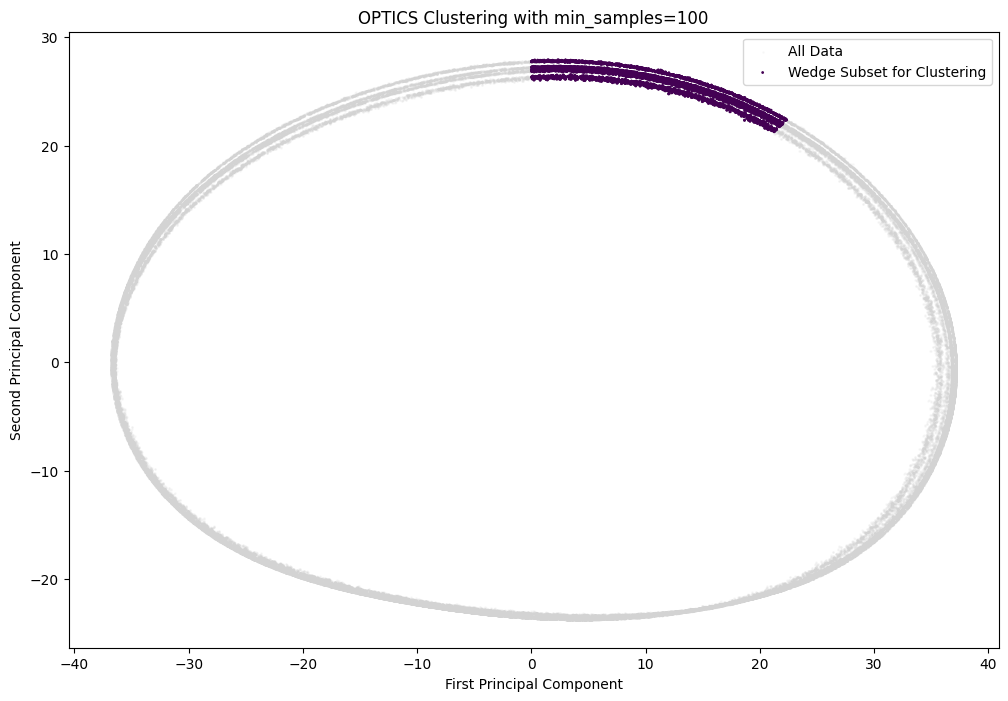

In [20]:
# Perform clustering in PCA space, using OPTICS

from sklearn.cluster import OPTICS

# Initialize the clustering algorithm (OPTICS as an example)

min_cluster_size = 100

# Add timing

# Add timing
start_time = time.time()

optics = OPTICS(
    min_samples=min_cluster_size)
    
cluster_labels = optics.fit_predict(subset_embeddings_pca)

# Add timing
end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")

# Visualize the clustering results

plt.figure(figsize=(12, 8))

# Plot all data points in light gray for context
plt.scatter(
    all_embeddings_pca[:, 0],
    all_embeddings_pca[:, 1],
    c="lightgray",
    marker='o',
    s=1,
    alpha=0.1,
    label='All Data'
)

# Overlay the wedge subset with cluster-based coloring
scatter = plt.scatter(
    subset_embeddings_pca[:, 0],
    subset_embeddings_pca[:, 1],
    c=cluster_labels,
    marker='o',
    s=1,
    label='Wedge Subset for Clustering'
)

# Add a legend
plt.legend()

# Set plot titles and labels
plt.title(f'OPTICS Clustering with min_samples={min_cluster_size}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Display the plot
plt.show()


## Graph-based clustering

Time taken: 42.82 seconds


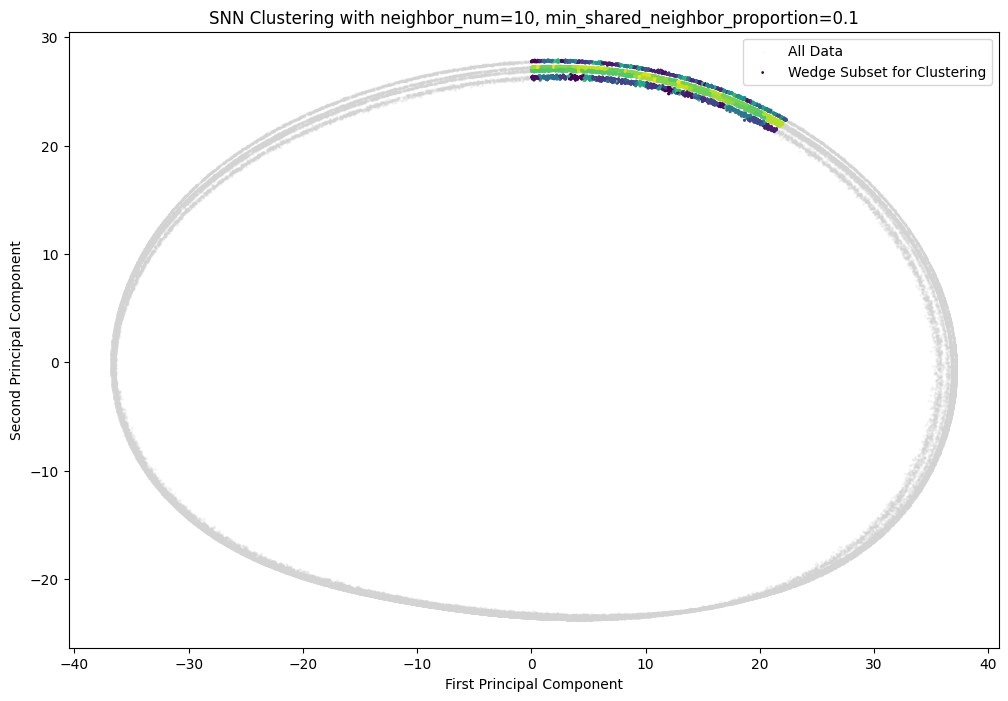

Time taken: 42.94 seconds


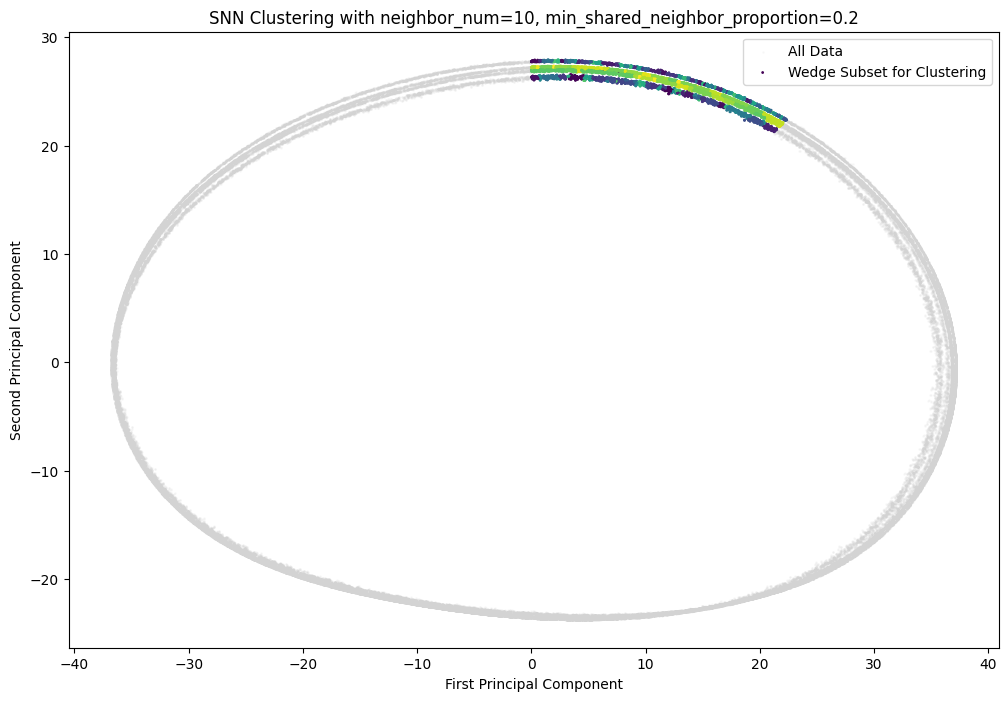

Time taken: 43.47 seconds


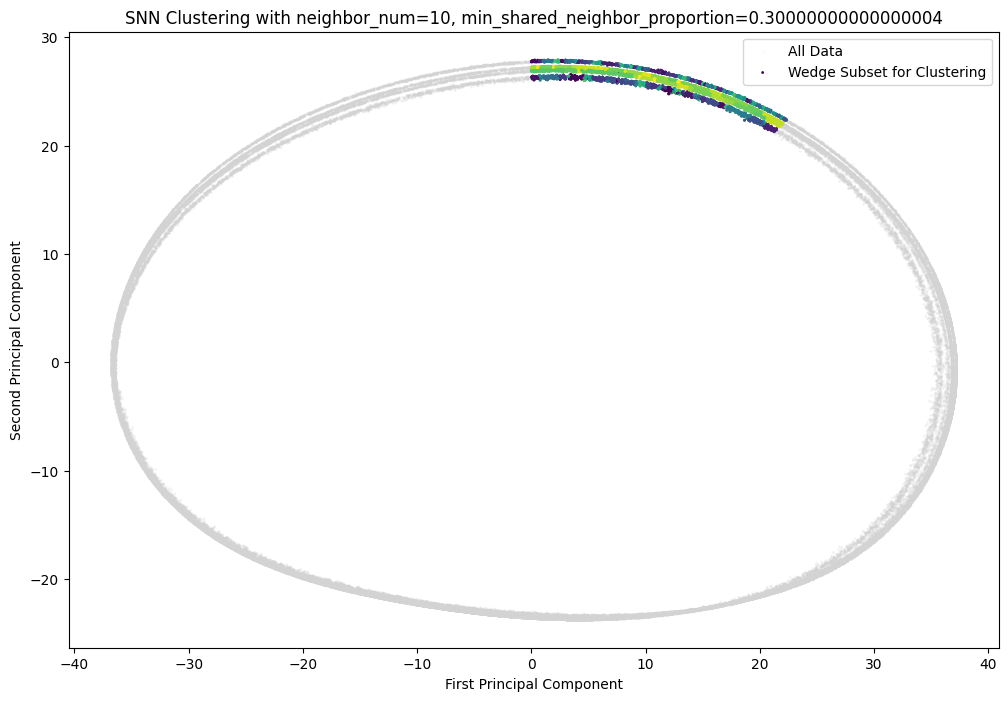

Time taken: 43.81 seconds


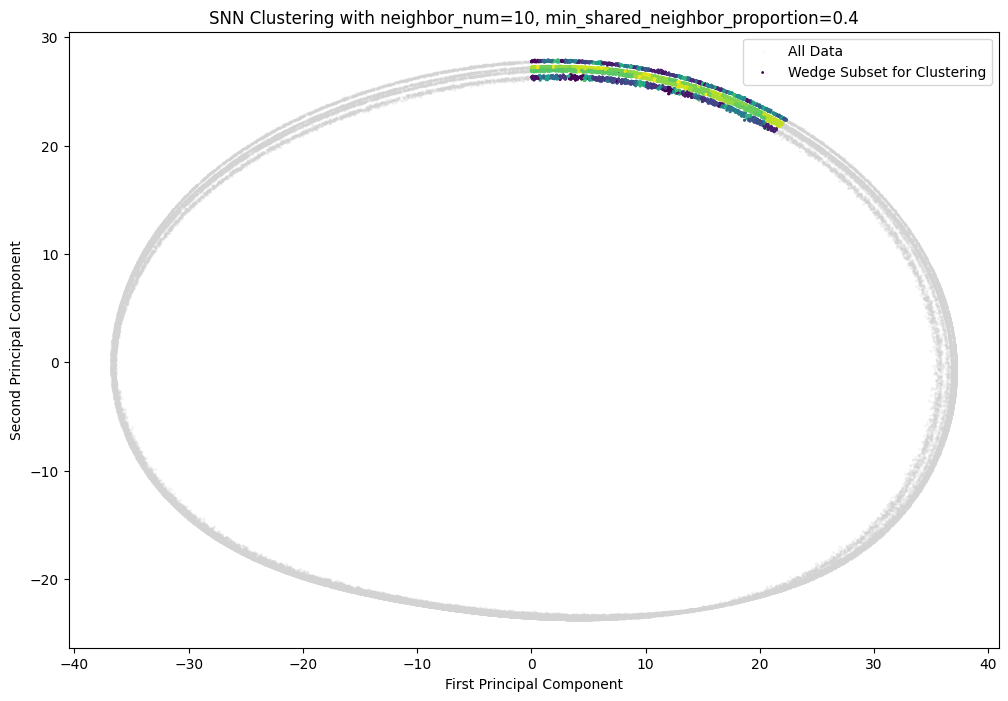

Time taken: 46.08 seconds


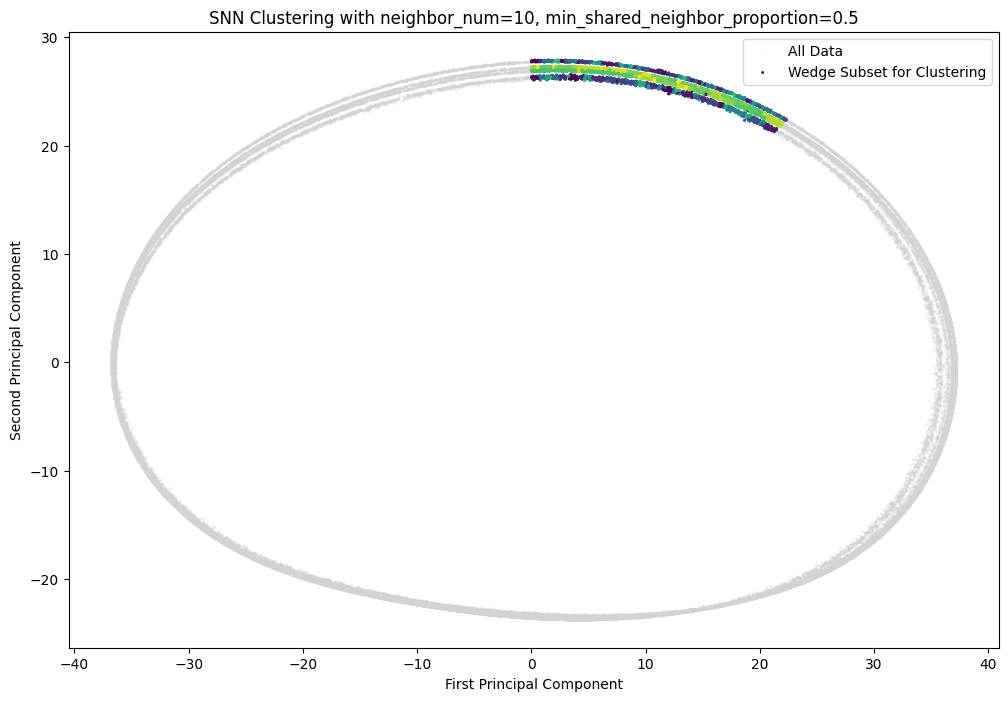

Time taken: 45.92 seconds


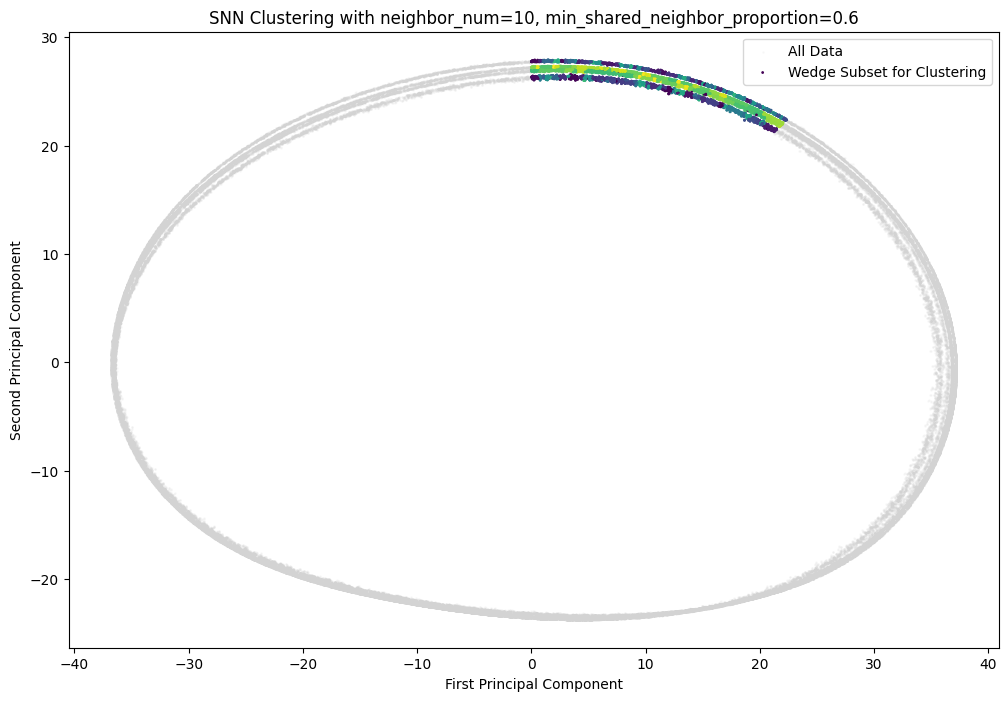

Time taken: 46.42 seconds


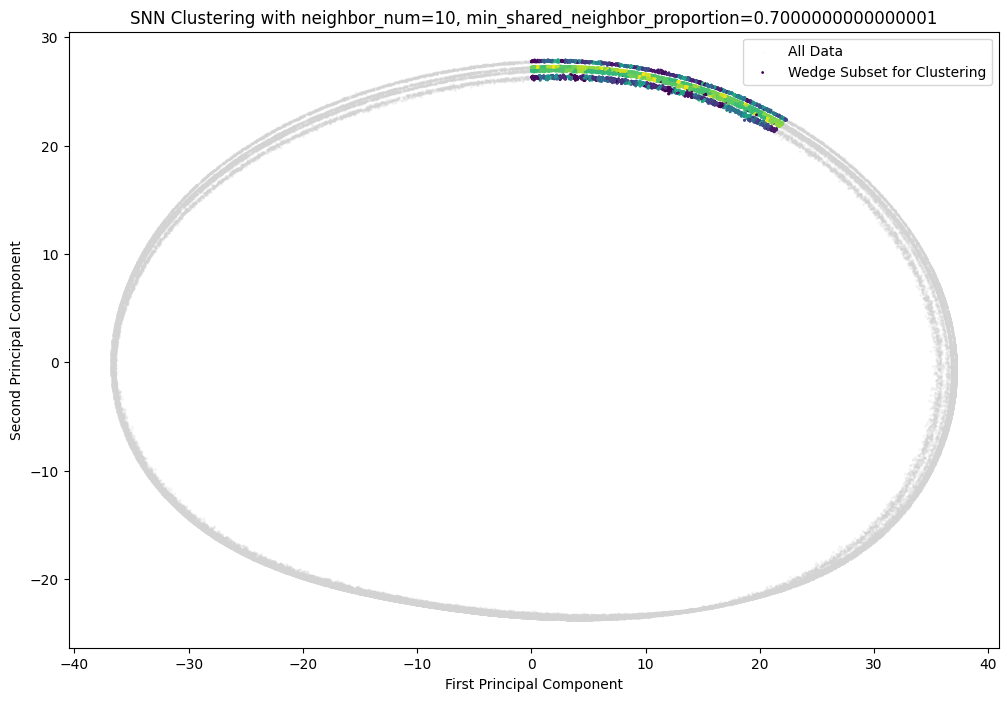

Time taken: 46.41 seconds


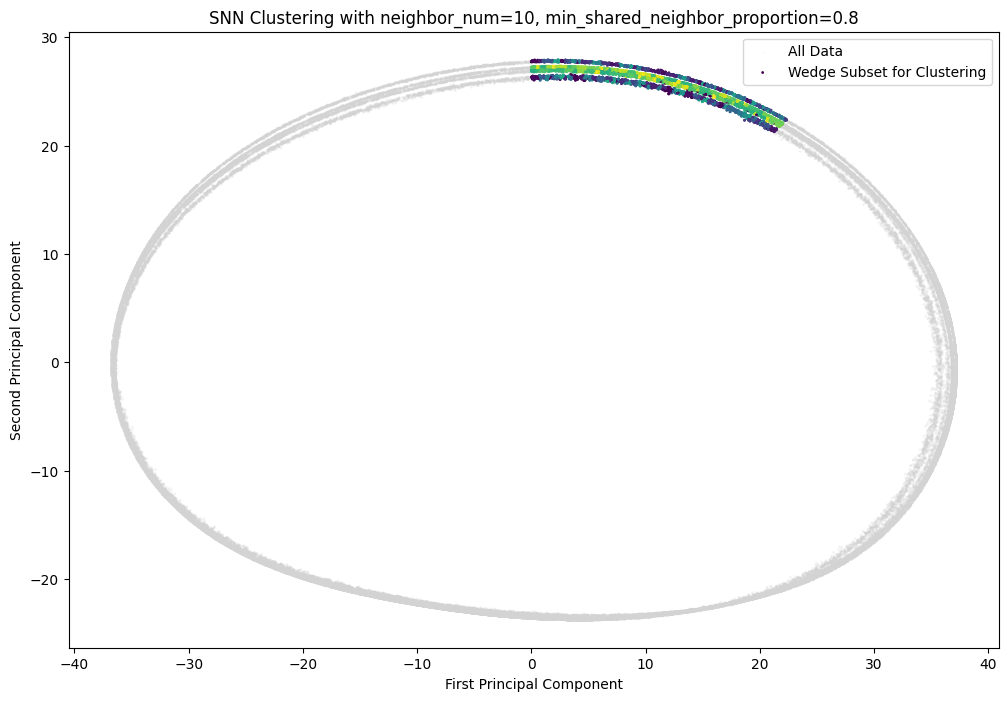

Time taken: 46.77 seconds


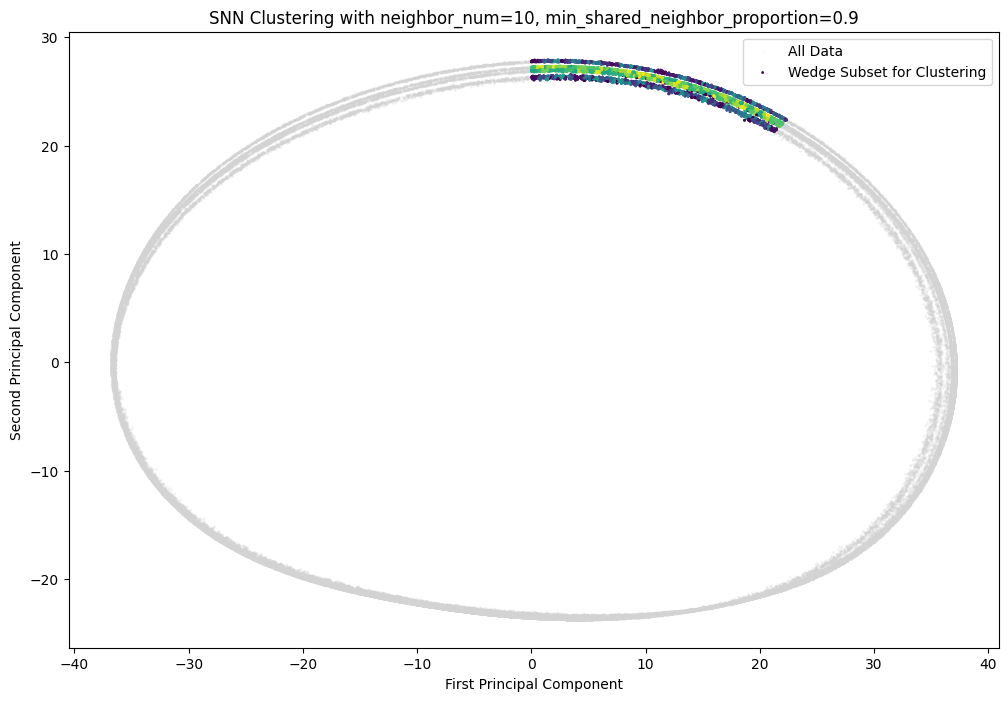

In [12]:
# Perform clustering in PCA space, using SNN

from snn_clustering.SNN.snn import SNN
import seaborn as sns
# Initialize the clustering algorithm (SNN as an example)

neighbor_num = 10
min_shared_neighbor_proportions = np.linspace(0.1, 0.9, 9)

for min_shared_neighbor_proportion in min_shared_neighbor_proportions:

    # Add timing
    start_time = time.time()

    snn = SNN(neighbor_num=neighbor_num, min_shared_neighbor_proportion=min_shared_neighbor_proportion)
    cluster_labels = snn.fit_predict(subset_embeddings_pca)

    # Add timing
    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Visualize the clustering results

    plt.figure(figsize=(12, 8))

    # Plot all data points in light gray for context
    plt.scatter(
        all_embeddings_pca[:, 0],
        all_embeddings_pca[:, 1],
        c="lightgray",
        marker='o',
        s=1,
        alpha=0.1,
        label='All Data'
    )

    # Overlay the wedge subset with cluster-based coloring
    scatter = plt.scatter(
        subset_embeddings_pca[:, 0],
        subset_embeddings_pca[:, 1],
        c=cluster_labels,
        marker='o',
        s=1,
        label='Wedge Subset for Clustering'
    )

    # Add a legend
    plt.legend()

    # Set plot titles and labels
    plt.title(f'SNN Clustering with neighbor_num={neighbor_num}, min_shared_neighbor_proportion={min_shared_neighbor_proportion}')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')

    # Display the plot
    plt.show()

<Axes: ylabel='Count'>

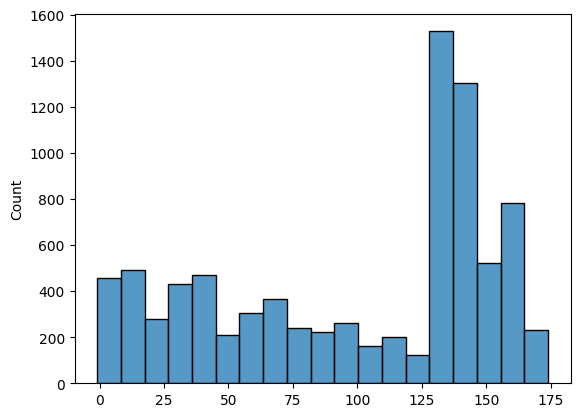

In [10]:
sns.histplot(cluster_labels)

## UMAP

In [5]:
# Import necessary libraries for manifold learning
import umap

# Step 1: Apply UMAP for Dimensionality Reduction
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    random_state=42
)

subset_embeddings_umap = reducer.fit_transform(subset_embeddings)


/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


IndexError: boolean index did not match indexed array along dimension 0; dimension is 8591 but corresponding boolean dimension is 80000

<Figure size 1000x600 with 0 Axes>

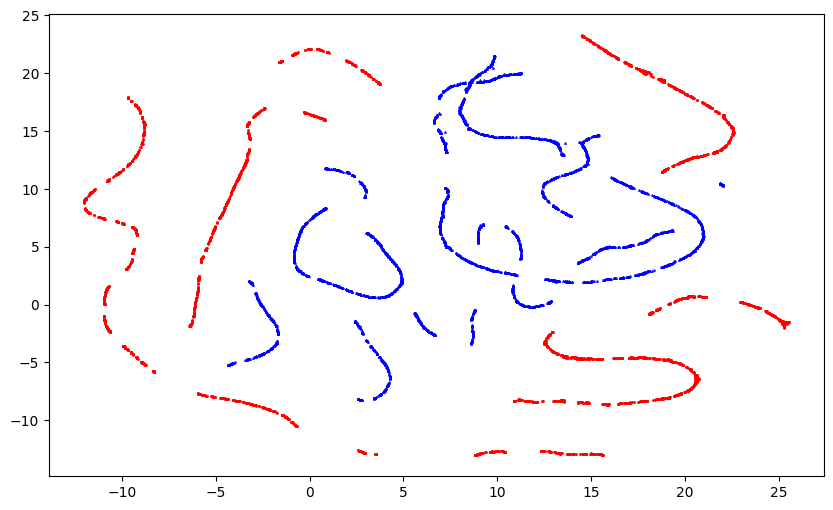

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(
    subset_embeddings_umap[subset_pt_mask, 0],
    subset_embeddings_umap[subset_pt_mask, 1],
    c="r",
    marker='o',
    label='Low pT',
    s=1
)

plt.scatter(
    subset_embeddings_umap[~subset_pt_mask, 0],
    subset_embeddings_umap[~subset_pt_mask, 1],
    c="b",
    marker='^',
    label='High pT',
    s=1
)



In [8]:
# Import necessary libraries for manifold learning
import umap

# Step 1: Apply UMAP for Dimensionality Reduction
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=1.0,
    metric='euclidean',
    random_state=42
)

subset_embeddings_umap = reducer.fit_transform(subset_embeddings)


/global/homes/d/danieltm/.conda/envs/jepa/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


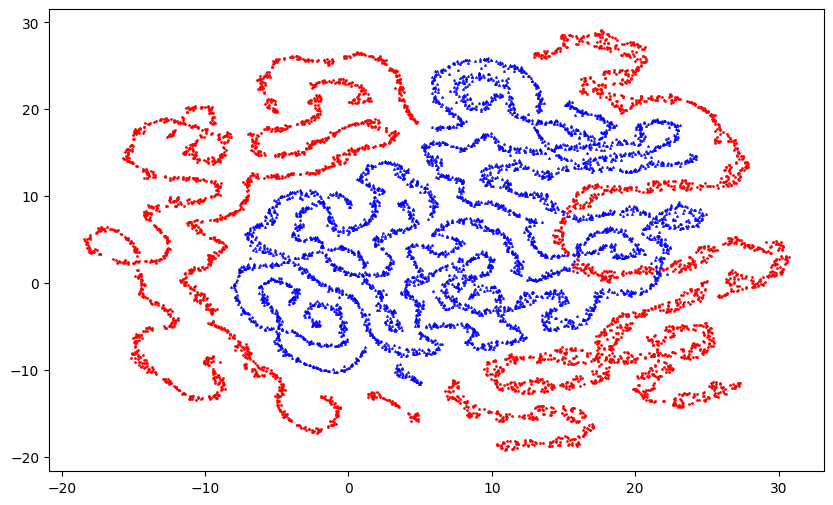

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(
    subset_embeddings_umap[subset_pt_mask, 0],
    subset_embeddings_umap[subset_pt_mask, 1],
    c="r",
    marker='o',
    label='Low pT',
    s=1
)

plt.scatter(
    subset_embeddings_umap[~subset_pt_mask, 0],
    subset_embeddings_umap[~subset_pt_mask, 1],
    c="b",
    marker='^',
    label='High pT',
    s=1
)

